# Содержание <a id="0"></a>

1. [Импортируем библиотеки и загружаем датасеты](#1)

2. [Предобработка данных](#2)

    2.1 [Данные о транзакциях](#21)
   
    2.1.1 [Пропуски в городах](#211)
    
    2.1.2 [Аномалии в цене товара](#212)
    
    2.1.3 [Аномалии в количестве товара](#213)
    
    2.2 [Данные о ценах конкурентов](#22)
    
    2.2.1 [Проверяем столбец с датой](#221)
    
    2.2.2 [Проверяем значения в столбцах со строками](#222)
    
    2.2.3 [Проверяем столбец с ценами](#223)
    
    2.3 [Данные о погоде](#23)
    
    2.4 [Данные о себестоимости](#24)
    
    2.4.1 [Проверяем данные в столбцах](#241)
    
3. [Промежуточный вывод 1](#3)

4. [Исследовательский анализ данных](#4)

    4.1 [Данные о транзакциях](#41)
    
    4.1.1 [Цена товара](#411)
    
    4.1.2 [Количество товара](#412)
    
    4.2 [Данные о ценах конкурентов](#42)
    
    4.3 [Данные о себестоимости](#43)
    
    4.4 [Данные о погоде](#44)
    
5. [Промежуточный вывод 2](#5)

6. [Подготовка признаков и обучение моделей](#6)

7. [Вывод](#7)

## Импортируем библиотеки и загружаем датасеты <a id="1"></a>

[К содержанию](#0)

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, mean_absolute_error,\
                            mean_absolute_percentage_error, make_scorer

STATE = np.random.RandomState(12345)

In [85]:
df_transaction = pd.read_parquet('data/transaction_df.parquet')
df_competitors = pd.read_parquet('data/df_competitors.parquet')
df_weather = pd.read_parquet('data/weather_df.parquet')
df_cost = pd.read_parquet('data/df_cost.parquet')

## Предобработка данных <a id="2"></a>

[К содержанию](#0)

### Данные о транзакциях <a id="21"></a>

In [86]:
df_transaction = df_transaction.rename(columns={'datetime': 'date'})
display(df_transaction.head(10))
df_transaction.info()

product    price    amount       place                date
0  Целебные травы     3.90  1.242125  Анор Лондо 2216-01-02 16:28:00
1  Целебные травы     3.90 -0.079689  Анор Лондо 2216-01-02 16:21:00
2  Целебные травы     3.90  0.882450  Анор Лондо 2216-01-02 03:03:00
3  Целебные травы     3.90  0.621377  Анор Лондо 2216-01-02 03:12:00
4  Целебные травы     3.90  1.367161  Анор Лондо 2216-01-02 05:33:00
5  Целебные травы -7154.53  1.988265  Анор Лондо 2216-01-02 13:57:00
6  Целебные травы     3.90  1.736619  Анор Лондо 2216-01-02 11:54:00
7  Целебные травы     3.90  1.208150  Анор Лондо 2216-01-02 06:53:00
8  Целебные травы     3.90  1.826042  Анор Лондо 2216-01-02 12:05:00
9  Целебные травы     3.90  1.983822  Анор Лондо 2216-01-02 01:55:00

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 875036 entries, 0 to 875035
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   product  875036 non-null  object        
 1   price    875036 non-null  float64       
 2   amount   875036 non-null  float64       
 3   place    874604 non-null  object        
 4   date     875036 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 33.4+ MB


In [87]:
print('Дубликаты: ', df_transaction.duplicated().sum())

Дубликаты:  0


Видим пропуски в столбце ```place```, также есть аномалии в столбцах с ценой и объёмом товара. Дубликаты отсутствуют.

In [88]:
first_date_t = df_transaction['date'].min()
last_date_t = df_transaction['date'].max()
transactions_period = f'Предоставлены данные по транзакциям за период с {first_date_t} по {last_date_t}'
print(transactions_period)

Предоставлены данные по транзакциям за период с 2216-01-02 00:08:00 по 2218-09-27 23:57:00


In [89]:
df_transaction['product'].unique()

array(['Целебные травы', 'Эльфийская пыльца', 'Эстус'], dtype=object)

В столбце с названиями товаров всё в порядке.

#### Пропуски в городах <a id="211"></a>

[К содержанию](#0)

In [90]:
display(df_transaction[df_transaction['place'].isnull()])

product    price    amount place                date
1411       Целебные травы     3.90  0.834557  None 2216-01-10 04:16:00
4699                Эстус     3.86 -0.307409  None 2216-01-31 05:09:00
6428                Эстус     3.89  1.235291  None 2216-02-15 20:59:00
8629                Эстус -6687.99 -0.468309  None 2216-03-03 19:42:00
11470   Эльфийская пыльца    11.69  0.761002  None 2216-03-22 06:22:00
...                   ...      ...       ...   ...                 ...
866797              Эстус     9.56  0.620677  None 2218-08-13 13:46:00
869754     Целебные травы    11.04  1.504157  None 2218-08-31 16:23:00
870093     Целебные травы    11.04  0.217367  None 2218-09-02 15:05:00
871726     Целебные травы    10.97  1.583244  None 2218-09-11 23:18:00
872421  Эльфийская пыльца    15.35  0.218910  None 2218-09-14 07:10:00

[432 rows x 5 columns]

Пропуски разряжены и не идут друг за другом. Упорядочим данные по городам и заполним пропуски предыдущим значением в столбце.

In [91]:
df_transaction = df_transaction.sort_values(by = 'place')
df_transaction['place'] = df_transaction['place'].bfill()
print('Города:', df_transaction['place'].unique())

Города: ['Анор Лондо' 'Врата Балдура' 'Кеджистан' 'Нокрон' 'Фалькония' None]


#### Аномалии в цене товара <a id="212"></a>

[К содержанию](#0)

Установим столбец с датой в качестве индекса и отсоритурем по возрастанию.

In [92]:
df_transaction.set_index('date', inplace=True)
df_transaction = df_transaction.sort_index(ascending=True)
df_transaction['price'].describe()

count    875036.000000
mean       -299.886482
std        1407.438729
min       -9998.990000
25%           6.850000
50%           9.730000
75%          13.800000
max          31.200000
Name: price, dtype: float64

In [93]:
display(df_transaction[df_transaction['price'] < 0])

product    price    amount          place
date                                                                    
2216-01-02 00:24:00  Эльфийская пыльца -5569.01 -0.017708  Врата Балдура
2216-01-02 00:28:00  Эльфийская пыльца  -347.40  0.670576      Кеджистан
2216-01-02 01:14:00     Целебные травы -3317.83  1.965978      Кеджистан
2216-01-02 01:39:00              Эстус -2629.47  0.346608  Врата Балдура
2216-01-02 02:58:00              Эстус -2090.27  0.100049  Врата Балдура
...                                ...      ...       ...            ...
2218-09-27 19:50:00              Эстус -6953.85  1.650295         Нокрон
2218-09-27 21:19:00     Целебные травы -2337.97  0.596697      Кеджистан
2218-09-27 21:28:00  Эльфийская пыльца -5444.88  0.328079      Кеджистан
2218-09-27 21:43:00     Целебные травы -5462.39  1.234802     Анор Лондо
2218-09-27 22:36:00              Эстус -4864.25  1.365866     Анор Лондо

[54321 rows x 4 columns]

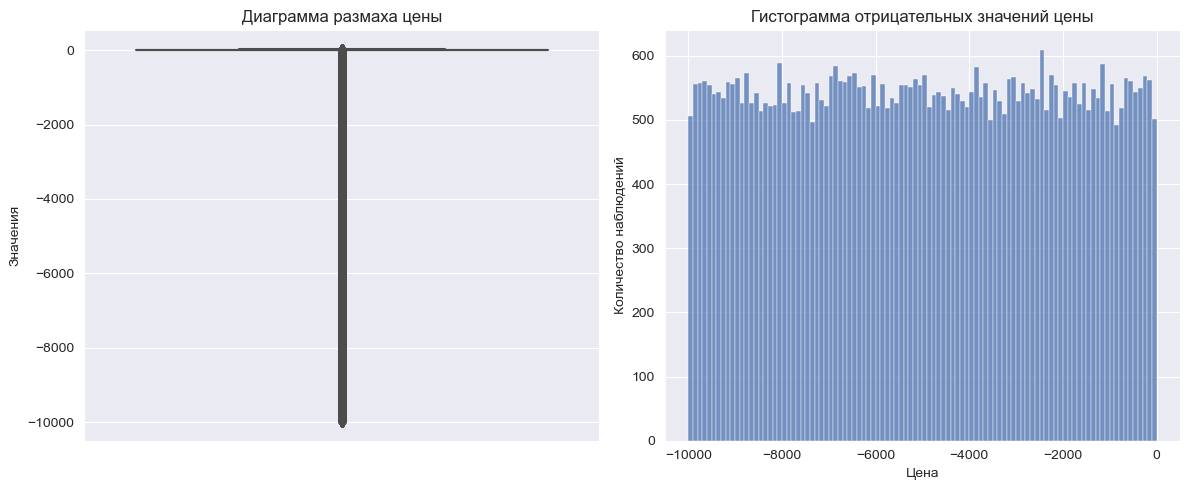

In [94]:
sns.set_style("darkgrid")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_transaction, y='price')
plt.title('Диаграмма размаха цены')
plt.ylabel('Значения')
plt.xlabel('')

plt.subplot(1, 2, 2)
sns.histplot(data=df_transaction[df_transaction['price'] < 0], x='price', bins=100)
plt.title('Гистограмма отрицательных значений цены')
plt.ylabel('Количество наблюдений')
plt.xlabel('Цена')

plt.tight_layout()
plt.show()

Видим, что в столбце присутствует большое количество выбросов с отрицательными значениями.

Распределение похоже на равномерное. Сложно что-либо сказать о природе аномальных значений, возможно, это ошибка выгрузки. Какой-либо системы в принимаемых значениях нет, пересчитать их, увы, не получится. 

Мы знаем, что:
- наши данные упорядочены
- данных много, в каждый день совершалось более одной транзакции
- аномалии не встречаются подряд друг за другом
- следующая цена не может отличаться от предыдущей больше, чем на 1 золотой 

Это позволяет нам заменить аномалии предыдущим значением цены.

In [95]:
pos = df_transaction['price'].where(df_transaction['price'] > 0, None)
df_transaction['price'] = df_transaction['price'].mask(df_transaction['price'] < 0, pos.bfill())

In [96]:
df_transaction['price'].describe()

count    875036.000000
mean         11.410359
std           5.400456
min           2.730000
25%           7.490000
50%          10.010000
75%          14.140000
max          31.200000
Name: price, dtype: float64

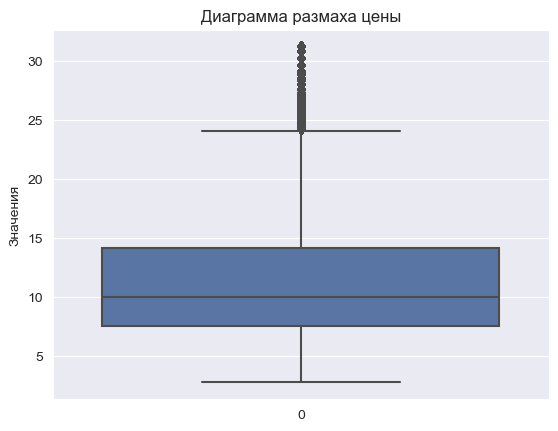

In [97]:
sns.boxplot(df_transaction['price'])
plt.title('Диаграмма размаха цены')
plt.ylabel('Значения')
plt.xlabel('');

Видим, что остались, в целом, адекватные по значению выбросы. Их мы трогать не будем, т.к. наша модель должна их учитывать и уметь работать с такими значениями.

Построим график цены для одного товара в одном городе.

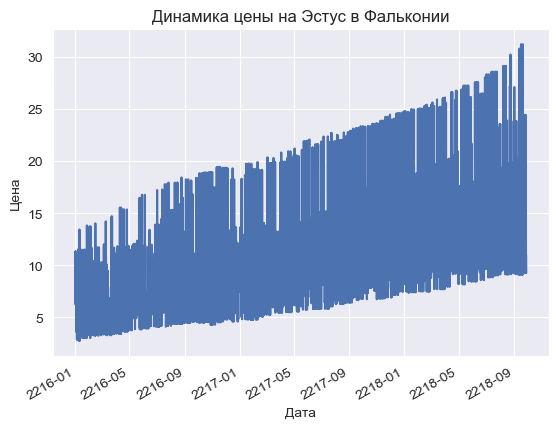

In [98]:
_ = df_transaction[(df_transaction['place'] == 'Фалькония') & (df_transaction['product'] == 'Эстус')]
_['price'].plot()
plt.title('Динамика цены на Эстус в Фальконии')
plt.ylabel('Цена')
plt.xlabel('Дата');

Увеличим масштаб до нескольких дней.

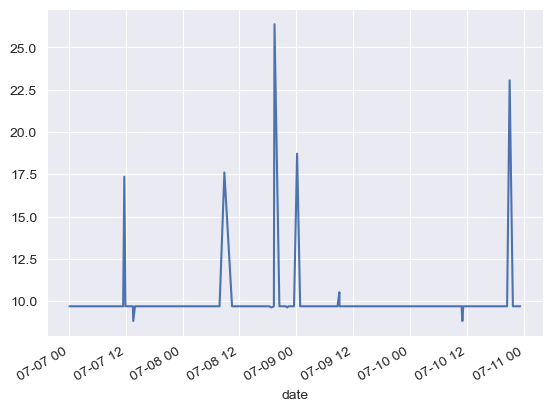

In [99]:
july_2216_data = _['price']['2218-07-07':'2218-07-10']
july_2216_data.plot();

Видим явные нарушения правил - изменения цены происходили чаще, чем раз в 3 дня и цена менялась больше, чем на 1 золотой. Неизвестно, были ли установлены эти правила в момент сбора данных, или нет, но, для качественного прогноза, лучше избавиться от таких данных.

Пройдёмся по всем данным продаж каждого товара в каждом городе. Для этого создадим вложенный словарь.

In [100]:
#словарь для хранения таблиц продаж
sales_dict = {}

# сгруппируем данные по 'product' и 'place' и сохраним их в отдельные таблицы
for (product, place), group in df_transaction.groupby(['product', 'place']):
    if product not in sales_dict:
        sales_dict[product] = {}

    sales_dict[product][place] = group[['price', 'amount']]


In [101]:
# функция-фильтр для удаления неподходящих данных
def remove_short_price_changes(df):
    df['price_change'] = df['price'].diff().ne(0).cumsum()
    for change_id, change_group in df.groupby('price_change'):
        if len(change_group) < 3 or (abs(change_group['price'].max() - change_group['price'].min()) > 1):
            df = df[df['price_change'] != change_id]
    df = df.drop(columns=['price_change'])
    return df

# применяем функцию к каждой таблице в словаре
for product, product_dict in sales_dict.items():
    for place, df in product_dict.items():
        df = remove_short_price_changes(df)
        product_dict[place] = df


/var/folders/0v/khfzfvln7tb5k2sbvh23_wv40000gn/T/ipykernel_71978/2726970069.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_change'] = df['price'].diff().ne(0).cumsum()


In [102]:
dfs = []
# идём по словарю и добавляем каждую таблицу в список
for product, product_dict in sales_dict.items():
    for place, df in product_dict.items():
        df['product'] = product
        df['place'] = place
        dfs.append(df)

# объедияем все таблицы в один датафрейм
df_transaction = pd.concat(dfs, ignore_index=False)

Проверяем нашу фильтрацию.

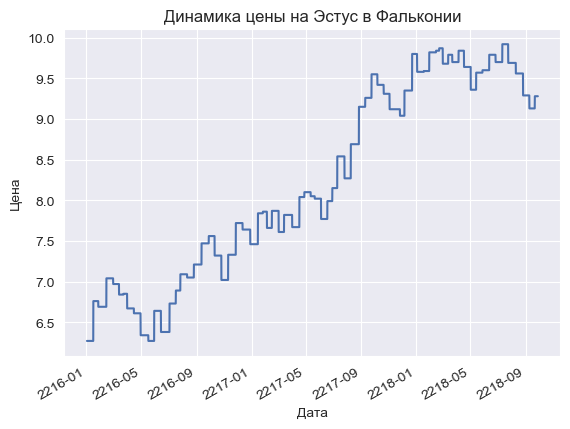

In [103]:
_ = df_transaction[(df_transaction['place'] == 'Фалькония') & (df_transaction['product'] == 'Эстус')]
_['price'].plot()
plt.title('Динамика цены на Эстус в Фальконии')
plt.ylabel('Цена')
plt.xlabel('Дата');

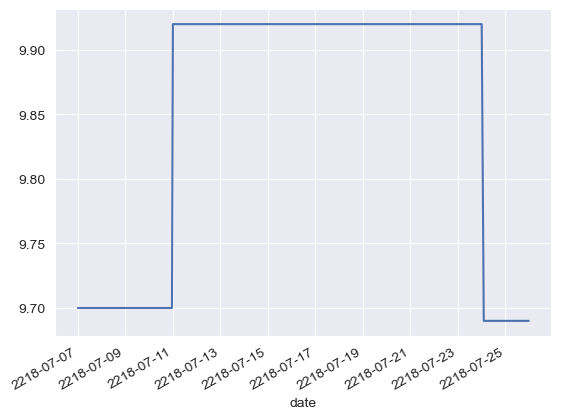

In [104]:
july_2216_data = _['price']['2218-07-07':'2218-07-25']
july_2216_data.plot();

Аномальные изменения цены устранены.

#### Аномалии в количестве товара <a id="213"></a>

In [105]:
df_transaction['amount'].describe()

count    815802.000000
mean          0.739311
std           0.717971
min          -0.500000
25%           0.119194
50%           0.733404
75%           1.356925
max           1.999999
Name: amount, dtype: float64

In [106]:
display(df_transaction[df_transaction['amount'] < 0])

price    amount         product       place
date                                                            
2216-01-02 03:52:00   3.90 -0.181400  Целебные травы  Анор Лондо
2216-01-02 04:20:00   3.90 -0.302981  Целебные травы  Анор Лондо
2216-01-02 09:32:00   3.90 -0.026968  Целебные травы  Анор Лондо
2216-01-02 10:01:00   3.90 -0.424848  Целебные травы  Анор Лондо
2216-01-02 14:22:00   3.90 -0.209384  Целебные травы  Анор Лондо
...                    ...       ...             ...         ...
2218-09-27 21:35:00   9.28 -0.469846           Эстус   Фалькония
2218-09-27 22:09:00   9.28 -0.064285           Эстус   Фалькония
2218-09-27 23:02:00   9.28 -0.187556           Эстус   Фалькония
2218-09-27 23:25:00   9.28 -0.006291           Эстус   Фалькония
2218-09-27 23:32:00   9.28 -0.026184           Эстус   Фалькония

[163762 rows x 4 columns]

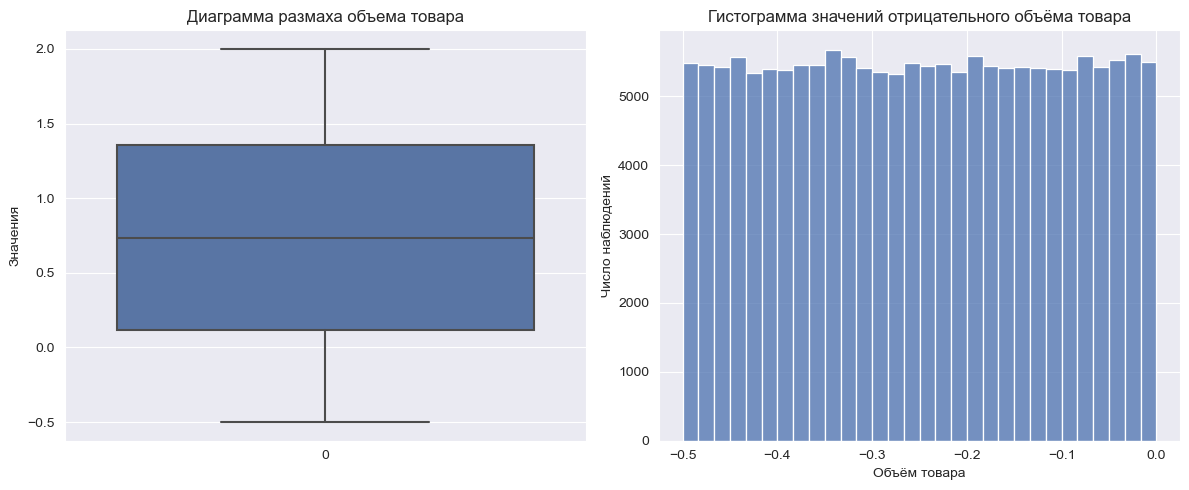

In [107]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(df_transaction['amount'])
plt.title('Диаграмма размаха объема товара')
plt.ylabel('Значения')
plt.xlabel('')

plt.subplot(1, 2, 2)
sns.histplot(df_transaction[df_transaction['amount'] < 0]['amount'], bins=30)
plt.title('Гистограмма значений отрицательного объёма товара')
plt.ylabel('Число наблюдений')
plt.xlabel('Объём товара')

plt.tight_layout()
plt.show();


Видим, что отрицательные значения в этом столбце не являются выбросами и имеют равномерное распределение. Это либо опечатка при заполнении, либо, опять же, ошибка при выгрузке данных. В любом случае, заменим отрицательные значения на такие же положительные.

In [108]:
df_transaction['amount'] = df_transaction['amount'].abs()

### Данные о ценах конкурентов <a id="22"></a>

[К содержанию](#0)

In [109]:
display(df_competitors.head(10))
df_competitors.info()

place         product   competitor  price       date
0   Анор Лондо  Целебные травы  Арториас&Co   3.78 2216-01-04
1   Анор Лондо  Целебные травы  Арториас&Co   3.78 2216-01-05
2   Анор Лондо  Целебные травы  Арториас&Co   3.78 2216-01-06
3   Анор Лондо  Целебные травы  Арториас&Co   3.78 2216-01-09
5   Анор Лондо  Целебные травы  Арториас&Co   3.78 2216-01-11
6   Анор Лондо  Целебные травы  Арториас&Co   3.78 2216-01-12
7   Анор Лондо  Целебные травы  Арториас&Co   3.78 2216-01-13
9   Анор Лондо  Целебные травы  Арториас&Co   4.03 2216-01-17
10  Анор Лондо  Целебные травы  Арториас&Co   4.03 2216-01-18
12  Анор Лондо  Целебные травы  Арториас&Co   4.03 2216-01-21

<class 'pandas.core.frame.DataFrame'>
Index: 31799 entries, 0 to 39456
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   place       31799 non-null  object        
 1   product     31799 non-null  object        
 2   competitor  31799 non-null  object        
 3   price       31799 non-null  float64       
 4   date        31799 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 1.5+ MB


#### Проверяем столбец с датой <a id="221"></a>

[К содержанию](#0)

In [110]:
df_competitors['date'].describe()

count                            31799
mean     2217-05-14 12:59:15.281613824
min                2216-01-02 00:00:00
25%                2216-09-07 12:00:00
50%                2217-05-15 00:00:00
75%                2218-01-19 00:00:00
max                2218-09-27 00:00:00
Name: date, dtype: object

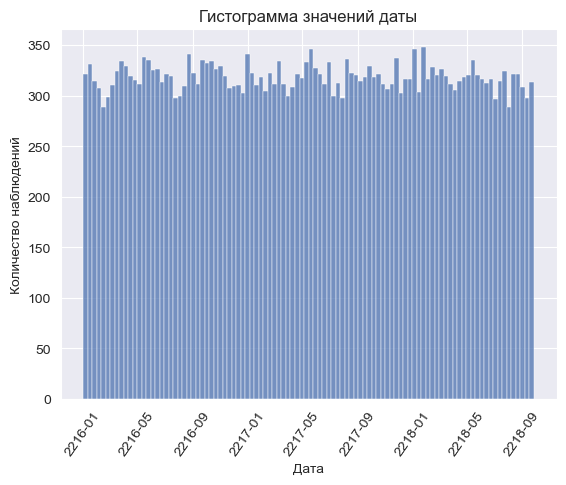

In [111]:
sns.histplot(df_competitors['date'], bins=100)
plt.title('Гистограмма значений даты')
plt.ylabel('Количество наблюдений')
plt.xlabel('Дата')
plt.xticks(rotation=55);

Данные распределены равномерно, и это нормально, т.к. это значения даты за определённый период. Каких-либо аномальных значений нет.

In [112]:
first_date_c = df_competitors['date'].min()
last_date_c = df_competitors['date'].max()
competitors_period = f'Предоставлены данные о ценах конкурентов за период с {first_date_c} по {last_date_c}'
print(competitors_period)
print(transactions_period)
print('Дубликаты: ', df_competitors.duplicated().sum())

Предоставлены данные о ценах конкурентов за период с 2216-01-02 00:00:00 по 2218-09-27 00:00:00
Предоставлены данные по транзакциям за период с 2216-01-02 00:08:00 по 2218-09-27 23:57:00
Дубликаты:  0


Данных меньше, но по дням они охватывают такой же временной промежуток, что и данные по транзакциям.

Пропуски и дубликаты отсутствуют.

In [113]:
df_competitors.set_index('date', inplace=True)
df_competitors = df_competitors.sort_index(ascending=True)

Построим графики изменений цены по каждому товару у каждого конкурента в разных городах.

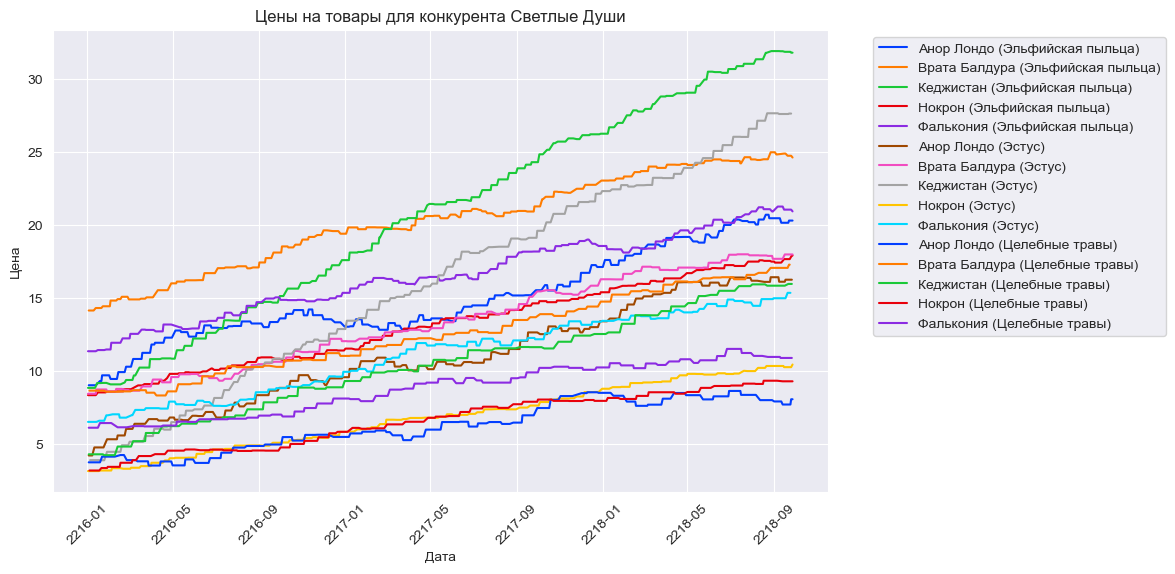

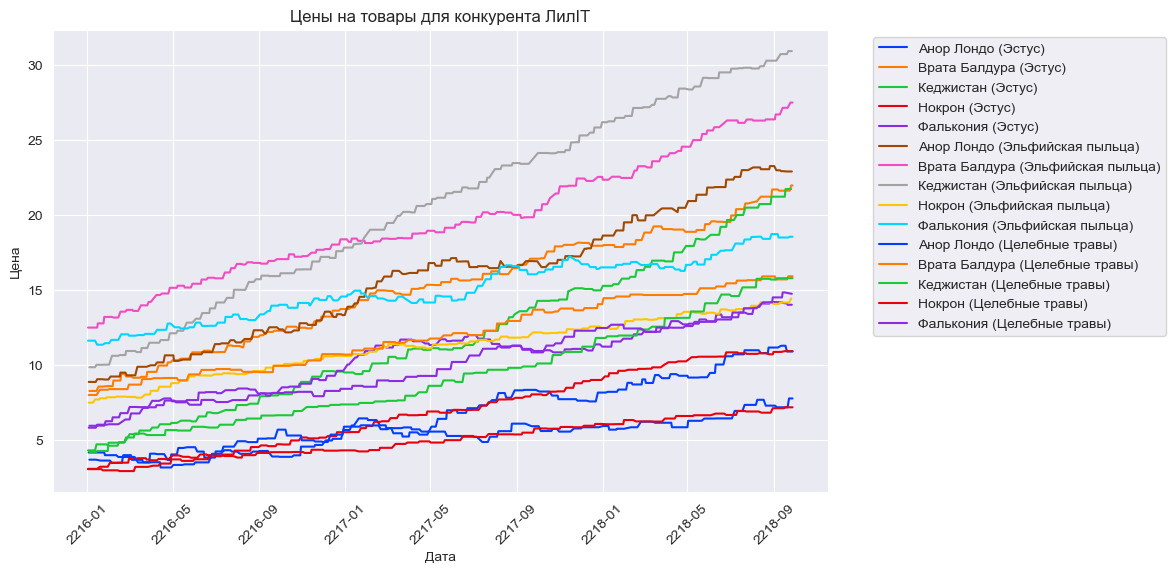

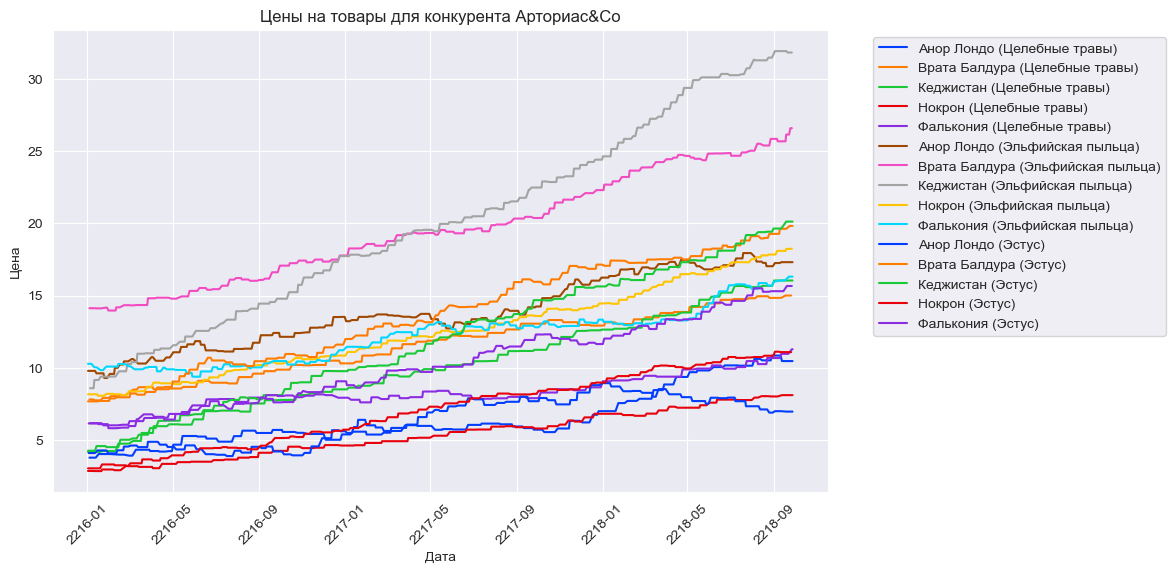

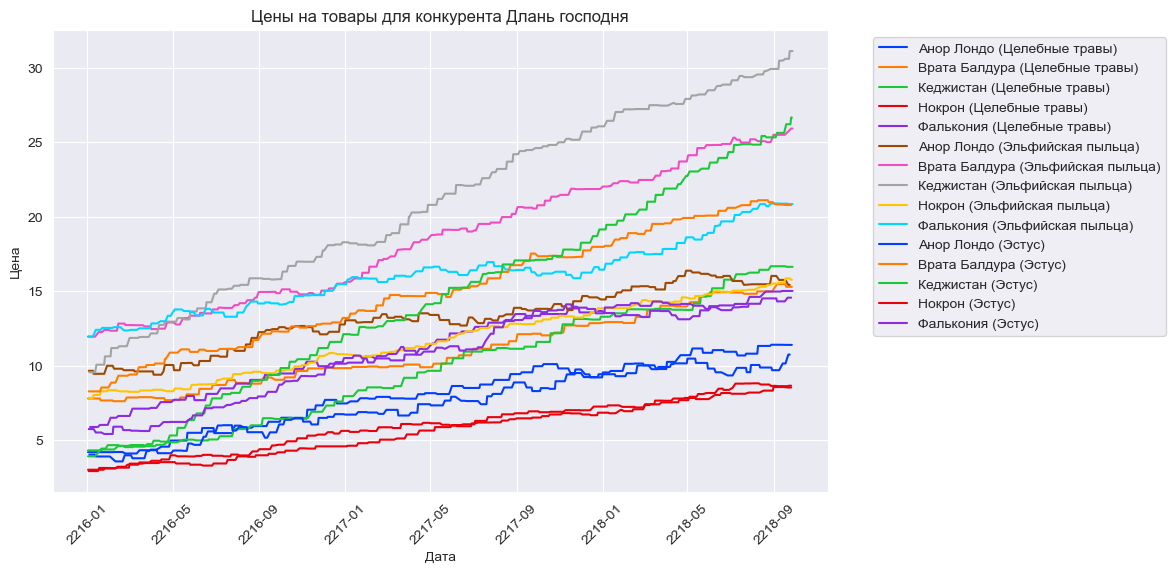

In [114]:
competitors = df_competitors['competitor'].unique()
sns.set_palette("bright")
for competitor in competitors:
    competitor_data = df_competitors[df_competitors['competitor'] == competitor]

    plt.figure(figsize=(10, 6))
    plt.title(f'Цены на товары для конкурента {competitor}')
    
    products = competitor_data['product'].unique()
    for product in products:
        product_data = competitor_data[competitor_data['product'] == product]
        
        for place, group in product_data.groupby('place'):
            sns.lineplot(data=group, x=group.index, y='price', label=f'{place} ({product})')
        
        plt.xlabel('Дата')
        plt.ylabel('Цена')
        plt.xticks(rotation=45)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

Изучив графики, можно увидеть, что в наших данных о ценах конкурентов правила ценообразования не нарушаются. Нет резких перепадов значений, видны «ступеньки», что говорит о том, что цена держалась какое-то время после выставления.

#### Проверим значения в столбцах со строками. <a id="222"></a>

[К содержанию](#0)

In [115]:
print('Города: ',df_competitors['place'].unique())
print('Товары:', df_competitors['product'].unique())
print('Конкуренты:', df_competitors['competitor'].unique())

Города:  ['Нокрон' 'Врата Балдура' 'Кеджистан' 'Фалькония' 'Анор Лондо']
Товары: ['Эльфийская пыльца' 'Эстус' 'Целебные травы']
Конкуренты: ['Светлые Души' 'ЛилIT' 'Арториас&Co' 'Длань господня']


Аномальных значений нет.

#### Проверяем столбец с ценами <a id="223"></a>

[К содержанию](#0)

In [116]:
df_competitors['price'].describe()

count    31799.000000
mean        11.894810
std          5.574935
min          2.850000
25%          7.780000
50%         11.050000
75%         15.030000
max         31.940000
Name: price, dtype: float64

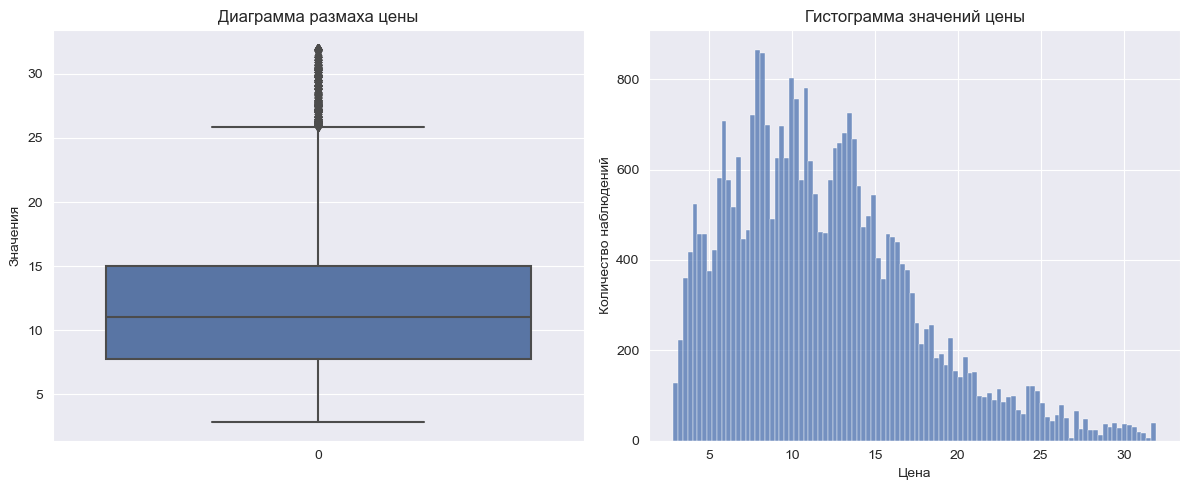

In [117]:
plt.figure(figsize=(12, 5))
sns.set_palette("deep")
plt.subplot(1, 2, 1)
sns.boxplot(df_competitors['price'])
plt.title('Диаграмма размаха цены')
plt.ylabel('Значения')
plt.xlabel('')

plt.subplot(1, 2, 2)
sns.histplot(df_competitors['price'], bins=100)
plt.title('Гистограмма значений цены')
plt.ylabel('Количество наблюдений')
plt.xlabel('Цена')

plt.tight_layout()
plt.show();


Выбросы присутствуют, но значения адекватные. На гистограмме видим нормальное распределение. Аномальных значений в данных о цене нет.

В датафрейме с ценами конкурентов с данными всё в порядке.

### Данные о погоде <a id="23"></a>

[К содержанию](#0)

In [118]:
display(df_weather.head(10))
df_weather.info()

place  hot  rain  snow       date
0      Фалькония    0     0     0 2216-01-02
1     Анор Лондо    1     0     0 2216-01-02
2  Врата Балдура    0     0     1 2216-01-02
3         Нокрон    0     0     0 2216-01-02
4      Кеджистан    0     0     1 2216-01-02
5      Фалькония    0     0     1 2216-01-03
6     Анор Лондо    1     0     0 2216-01-03
7  Врата Балдура    0     0     1 2216-01-03
8         Нокрон    0     0     1 2216-01-03
9      Кеджистан    0     0     0 2216-01-03

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   place   5000 non-null   object        
 1   hot     5000 non-null   int64         
 2   rain    5000 non-null   int64         
 3   snow    5000 non-null   int64         
 4   date    5000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 195.4+ KB


In [119]:
first_date_w = df_weather['date'].min()
last_date_w = df_weather['date'].max()
weather_period = f'Предоставлены данные о погоде за период с {first_date_w} по {last_date_w}'
print(weather_period)
print(competitors_period)
print(transactions_period)

Предоставлены данные о погоде за период с 2216-01-02 00:00:00 по 2218-09-27 00:00:00
Предоставлены данные о ценах конкурентов за период с 2216-01-02 00:00:00 по 2218-09-27 00:00:00
Предоставлены данные по транзакциям за период с 2216-01-02 00:08:00 по 2218-09-27 23:57:00


In [120]:
print('Дубликаты: ', df_weather.duplicated().sum())

Дубликаты:  0


Период предоставленных данных совпадает с предыдущими датасетами, пропусков и дубликатов нет. 

Сразу же бросается в глаза первая строка: есть случаи, когда в записи нет информации о погоде - везде стоят нули.

Проверим значения в столбцах.

In [121]:
print('Города: ', df_weather['place'].unique())
print('Жара: ', df_weather['hot'].unique())
print('Дождь: ', df_weather['rain'].unique())
print('Снег: ', df_weather['snow'].unique())

Города:  ['Фалькония' 'Анор Лондо' 'Врата Балдура' 'Нокрон' 'Кеджистан']
Жара:  [0 1]
Дождь:  [0 1]
Снег:  [0 1]


Аномальных значений нет.

In [122]:
print(df_weather[(df_weather['hot'] == 0) & (df_weather['rain'] == 0) & (df_weather['snow'] == 0)])

           place  hot  rain  snow       date
0      Фалькония    0     0     0 2216-01-02
3         Нокрон    0     0     0 2216-01-02
9      Кеджистан    0     0     0 2216-01-03
11    Анор Лондо    0     0     0 2216-01-04
15     Фалькония    0     0     0 2216-01-05
...          ...  ...   ...   ...        ...
4993      Нокрон    0     0     0 2218-09-26
4994   Кеджистан    0     0     0 2218-09-26
4995   Фалькония    0     0     0 2218-09-27
4998      Нокрон    0     0     0 2218-09-27
4999   Кеджистан    0     0     0 2218-09-27

[2425 rows x 5 columns]


Всё грустно, в половине записей отсутствуют данные о погоде. Два варианта, как это решить:
- взять данные из ближашей даты, когда погодные условия были известны;
- однако, в столбцах мы видим данные только об осадках и аномальной жаре. Наболее логичный вывод, что в дни, когда эти метки не проставлены, была относительно нормальная погода (насколько она нормальной может быть в постапокалиптическом мире будущего, где торгуют пыльцой и травами...). Введём для таких случаев новый столбец ```normal```.

In [123]:
df_weather['normal'] = 0
df_weather.loc[(df_weather['hot'] == 0) & \
               (df_weather['rain'] == 0) & \
               (df_weather['snow'] == 0), 'normal'] = 1
df_weather = df_weather[['date', 'place', 'hot', 'rain', 'snow', 'normal']]

In [124]:
df_weather.head()

date          place  hot  rain  snow  normal
0 2216-01-02      Фалькония    0     0     0       1
1 2216-01-02     Анор Лондо    1     0     0       0
2 2216-01-02  Врата Балдура    0     0     1       0
3 2216-01-02         Нокрон    0     0     0       1
4 2216-01-02      Кеджистан    0     0     1       0

### Данные о себестоимости <a id="24"></a>

[К содержанию](#0)

In [125]:
display(df_cost.head(10))
df_cost.info()

place         product  cost       date
0  Анор Лондо  Целебные травы  2.07 2216-01-02
1  Анор Лондо  Целебные травы  3.07 2216-01-26
2  Анор Лондо  Целебные травы  3.30 2216-02-12
3  Анор Лондо  Целебные травы  4.04 2216-03-06
4  Анор Лондо  Целебные травы  3.88 2216-03-27
5  Анор Лондо  Целебные травы  2.49 2216-04-18
6  Анор Лондо  Целебные травы  2.40 2216-05-01
7  Анор Лондо  Целебные травы  4.63 2216-05-18
8  Анор Лондо  Целебные травы  4.47 2216-06-08
9  Анор Лондо  Целебные травы  3.79 2216-06-24

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117 entries, 0 to 1116
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   place    1117 non-null   object        
 1   product  1117 non-null   object        
 2   cost     1117 non-null   float64       
 3   date     1117 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 35.0+ KB


In [126]:
first_date_cc = df_cost['date'].min()
last_date_cc = df_cost['date'].max()
cost_period = f'Предоставлены данные о себестоимости за период с {first_date_cc} по {last_date_cc}'
print(cost_period)
print(transactions_period)
print(competitors_period)
print(weather_period)

Предоставлены данные о себестоимости за период с 2216-01-02 00:00:00 по 2218-09-27 00:00:00
Предоставлены данные по транзакциям за период с 2216-01-02 00:08:00 по 2218-09-27 23:57:00
Предоставлены данные о ценах конкурентов за период с 2216-01-02 00:00:00 по 2218-09-27 00:00:00
Предоставлены данные о погоде за период с 2216-01-02 00:00:00 по 2218-09-27 00:00:00


In [127]:
print('Дубликаты: ', df_cost.duplicated().sum())

Дубликаты:  0


Данных очень мало. Период данных совпадает с предыдущими. Пропусков и дубликатов нет.

#### Проверяем значения в столбцах <a id="241"></a>

[К содержанию](#0)

In [128]:
print('Города:', df_cost['place'].unique())
print('Товары:', df_cost['product'].unique())

Города: ['Анор Лондо' 'Врата Балдура' 'Кеджистан' 'Нокрон' 'Фалькония']
Товары: ['Целебные травы' 'Эльфийская пыльца' 'Эстус']


Аномальных значений нет.

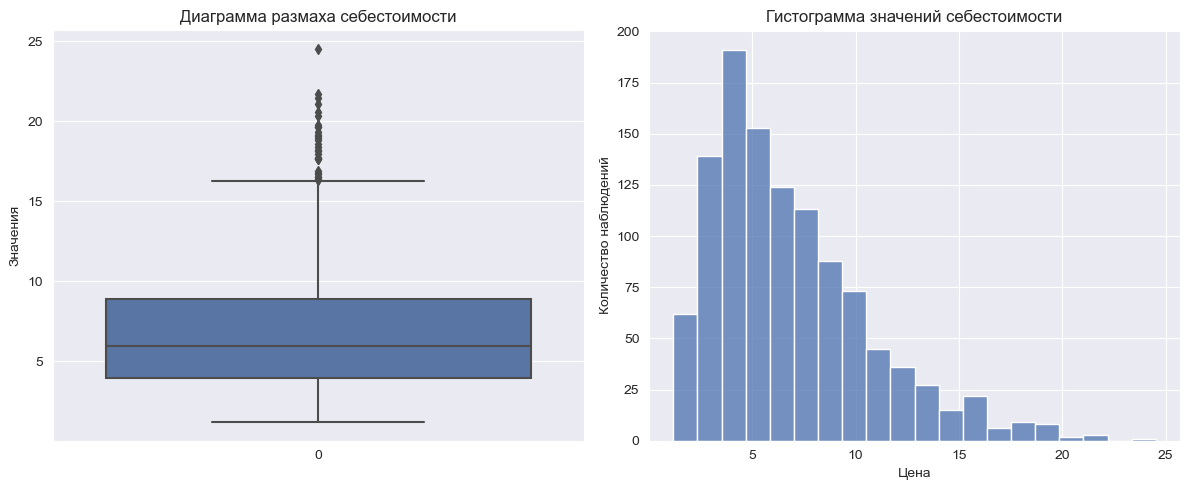

In [129]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(df_cost['cost'])
plt.title('Диаграмма размаха себестоимости')
plt.ylabel('Значения')
plt.xlabel('')

plt.subplot(1, 2, 2)
sns.histplot(df_cost['cost'], bins=20)
plt.title('Гистограмма значений себестоимости')
plt.ylabel('Количество наблюдений')
plt.xlabel('Цена')

plt.tight_layout()
plt.show();

Данные распределены нормально, присутствуют выбросы, но аномальных значений нет. С данными в этом датафрейме всё в порядке.

## Промежуточный вывод <a id="3"></a>

[К содержанию](#0)

Данные загружены и изучены, выполнена предобработка:
- в данных о транзакциях:
    - основывась на имеющихся данных об аномалиях, пропуски в городах и отрицательные значения в цене заполнены соседними значениями
    - удалены изменения цены, не соответствующие правилам (если новая цена держалась меньше 3 дней или изменилась больше чем на 1)
    - основываясь на значениях аномалий, отрицательные значения в количестве товара были заменены на такие же положительные
- в данных о погоде обработаны строки с нулями во всех категориях — добавлен столбец ```normal```, означающий нормальную погоду, без жары, дождя или снега

Все данные предоставлены за один и тот же период.

## Исследовательский анализ данных <a id="4"></a>

[К содержанию](#0)

### Данные о транзакциях <a id="41"></a>

#### Цена товара <a id="411"></a>

Сгруппируем данные по товарам, и создадим словарь, в котором каждому товару соответствует своя таблица данных.

In [130]:
grouped_data = df_transaction.groupby('product')

product_tables = {}
for product, product_group in grouped_data:
    product_tables[product] = product_group

Для каждой таблицы выполним ресемплирование данных по 1 дню. Возьмем среднюю цену и суммарный объем проданных товаров.

In [131]:
resampled = []
for i in product_tables.keys():
    for p in product_tables[i]['place'].unique():
        _ = product_tables[i][product_tables[i]['place']==p]
        resampled_data = _.resample('D').agg({'product': 'first',\
                                              'place': 'first',\
                                              'price': 'mean',\
                                              'amount': 'sum'})
        resampled_data = resampled_data.reindex(index=pd.date_range(start=first_date_cc, end=last_date_cc, freq='D'))
        resampled_data = resampled_data.ffill()
        resampled_data.index.name = 'date'
        resampled.append(resampled_data)
        


Создадим вложенный словарь ресемплированных данных для удобного обращения
```product_data_dict['Имя_товара']['Имя_города']```

In [132]:
product_data_dict = {}

for table in resampled:
    product_name = table['product'].iloc[0]
    place_name = table['place'].iloc[0]
    if product_name not in product_data_dict:
        product_data_dict[product_name] = {}
    product_data_dict[product_name][place_name] = table

Построим графики линий трендов для цены каждого товара в каждом городе. Упорядочим их по товарам и городам и разместим в сетке 5х3.

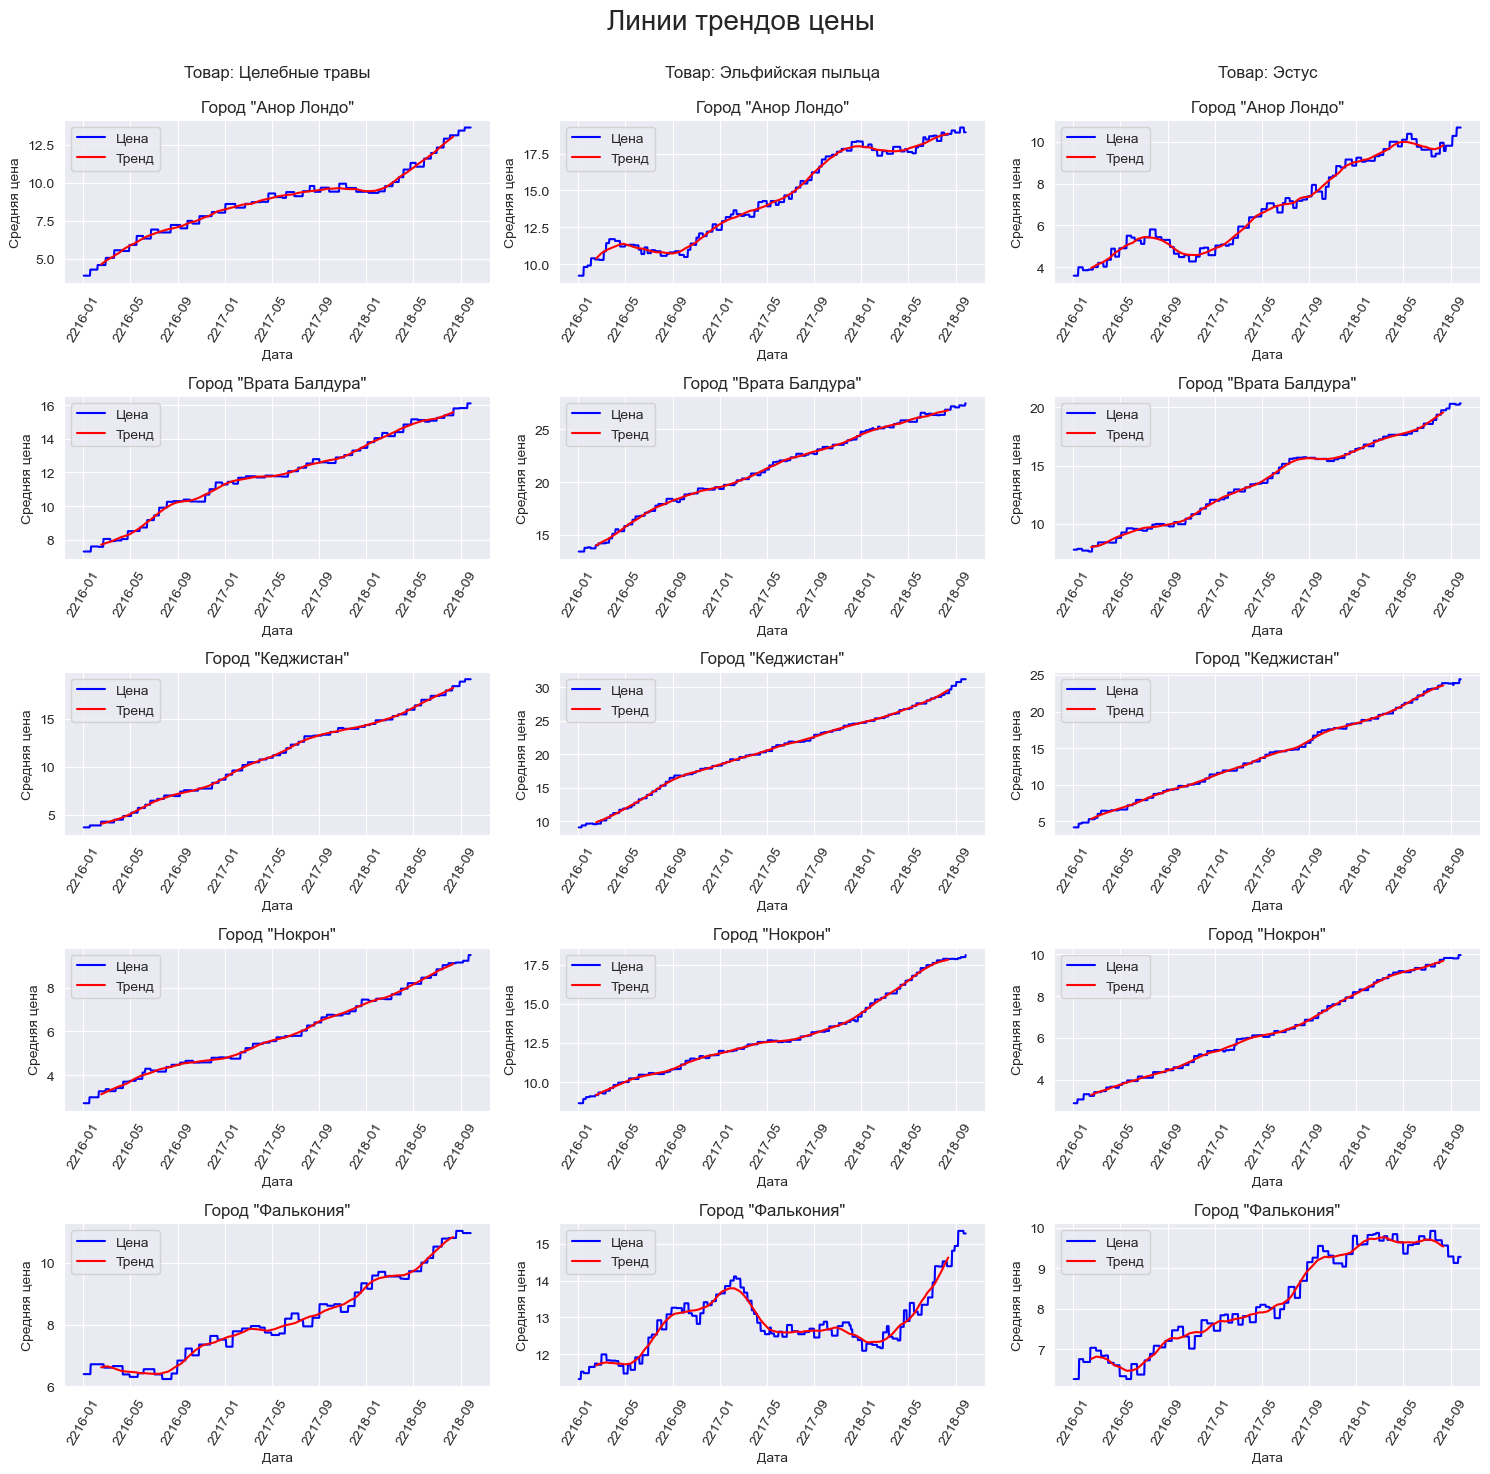

In [133]:
num_cols, num_rows = len(product_data_dict), len(list(product_data_dict.values())[0])
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# идем по словарю и индексам сетки для каждого товара и города
for col, (product, city_data) in enumerate(product_data_dict.items()):
    # сортируем по названию города для вывода по горизонтали одинаковых городов
    city_data_sorted = sorted(city_data.items(), key=lambda x: x[0])
    for row, (city, table) in enumerate(city_data_sorted):

        # применяем seasonal_decompose и получаем тренд
        decomposition = seasonal_decompose(table['price'], model='additive', period=90)
        trend = decomposition.trend

        # местоположение графика
        ax = axes[row, col]

        # строим график цены
        sns.lineplot(data=table['price'], ax=ax, color='blue', label='Цена')
        ax.set_xlabel('Дата')
        ax.set_ylabel('Средняя цена')
        ax.set_title(f'Город "{city}"', fontsize=12)

        # если это первый график в группе города, добавляем заголовок с названием товара
        if row == 0:
            ax.set_title(f'Товар: {product}\n \n{ax.get_title()}', fontsize=12)

        # строим график тренда
        sns.lineplot(data=trend, ax=ax, color='red', label='Тренд')

fig.suptitle('Линии трендов цены \n', fontsize=20)

for ax in axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(60)

# добавляем легенду
for ax in axes.flat:
    ax.legend()

plt.tight_layout()
plt.show()

Самые «стабильные» города — это Врата Балдура, Кеджистан и Нокрон. В них мы видим стабильное увеличение цены на протяжении всего периода.

Мы видим возрастающую линию тренда во всех случах, однако, в Анор Лондо и, особенно, в Фальконии, присутствуют выраженные просадки.

По аналогии построим графики сезонности для цены каждого товара в каждом городе.

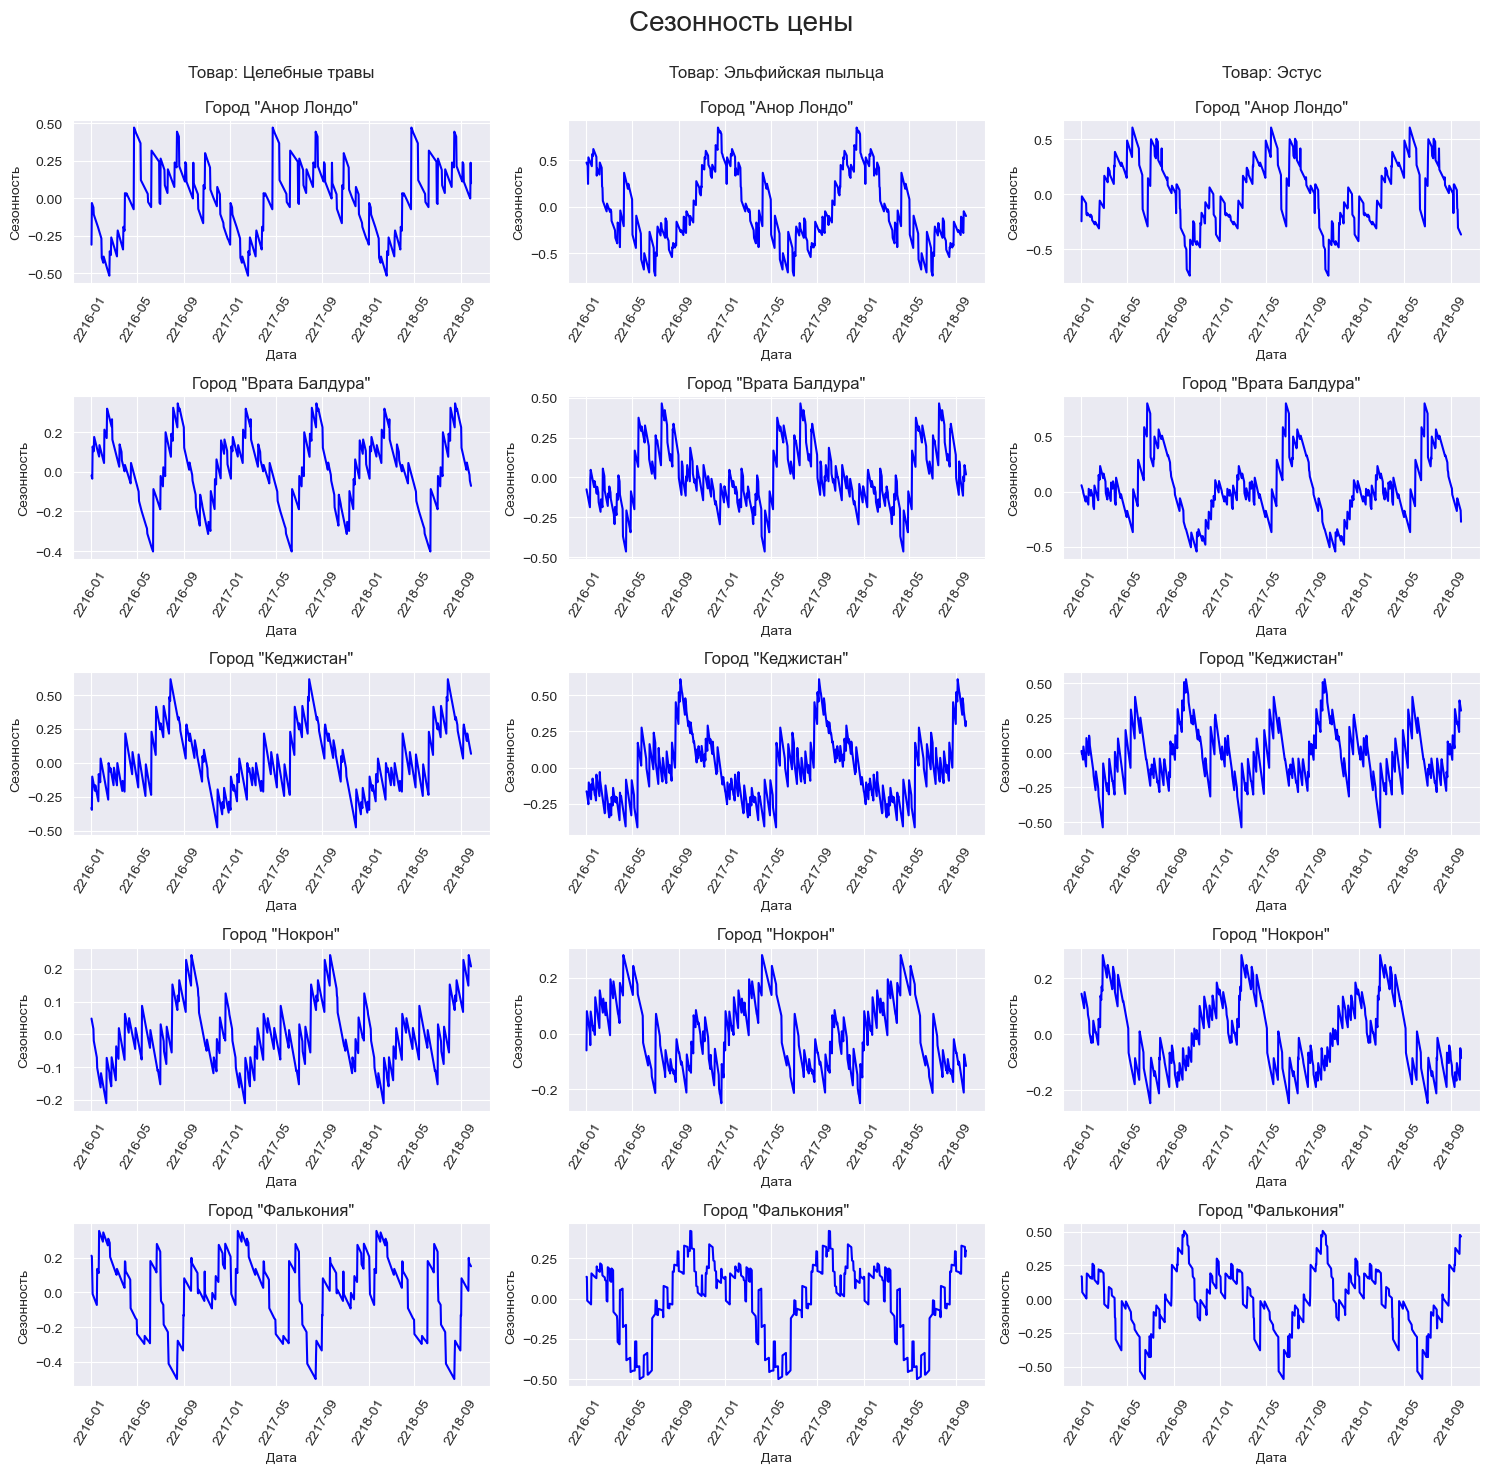

In [134]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for col, (product, city_data) in enumerate(product_data_dict.items()):
    city_data_sorted = sorted(city_data.items(), key=lambda x: x[0])
    for row, (city, table) in enumerate(city_data_sorted):

        decomposition = seasonal_decompose(table['price'], model='additive', period=365)
        seasonal = decomposition.seasonal

        ax = axes[row, col]
        sns.lineplot(data=seasonal, ax=ax, color='blue')
        ax.set_xlabel('Дата')
        ax.set_ylabel('Сезонность')
        ax.set_title(f'Город "{city}"', fontsize=12)

        if row == 0:
            ax.set_title(f'Товар: {product}\n \n{ax.get_title()}', fontsize=12)

fig.suptitle('Сезонность цены \n', fontsize=20)

for ax in axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(60)

plt.tight_layout()
plt.show()

Полный цикл сезонности занимает 1 год. На его протяжении есть свои периоды роста и спада. Нам важно определить, какую часть данных мы будем использовать для прогноза цен на товары в каждом конкретном городе.

#### Количество товара <a id="412"></a>

[К содержанию](#0)

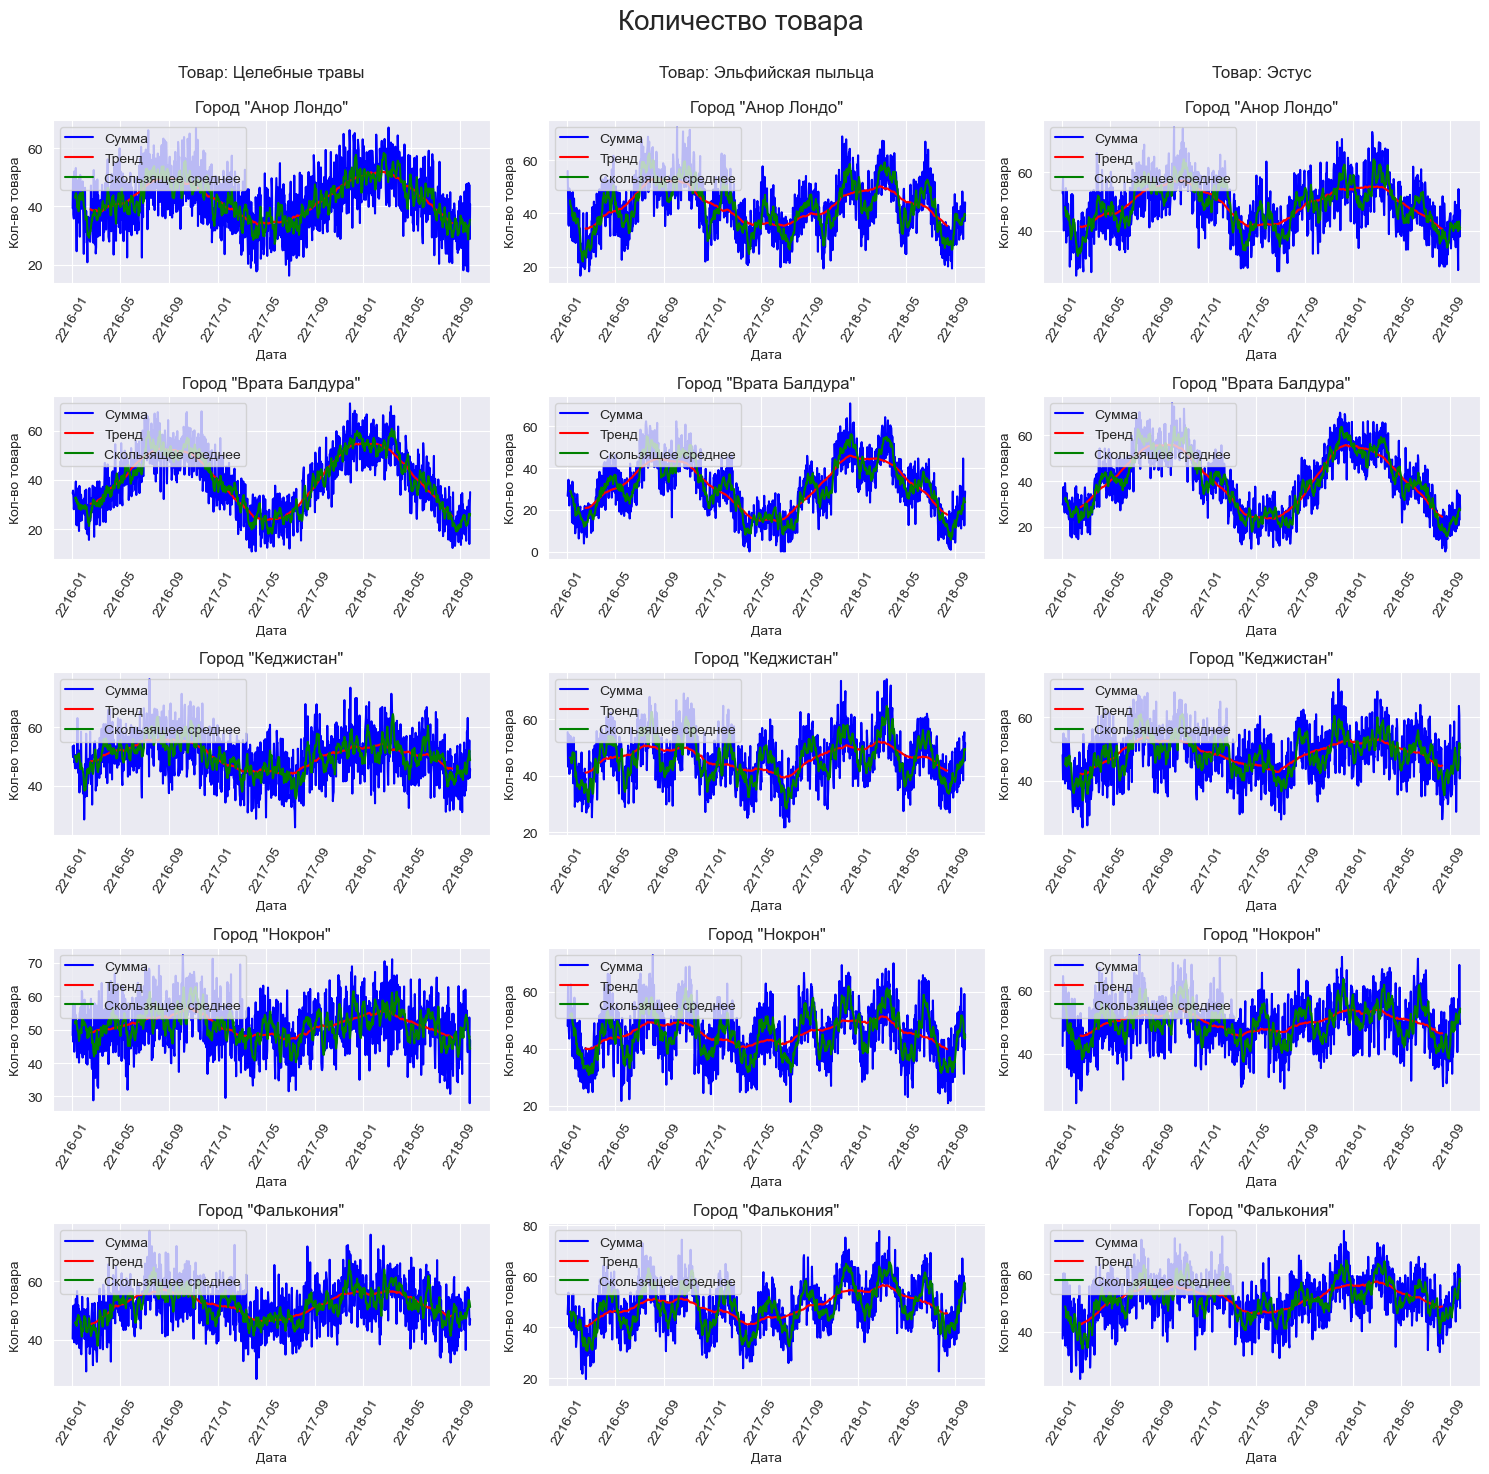

In [135]:
num_cols, num_rows = len(product_data_dict), len(list(product_data_dict.values())[0])
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# идем по словарю и индексам сетки для каждого товара и города
for col, (product, city_data) in enumerate(product_data_dict.items()):
    # сортируем по названию города для вывода по горизонтали одинаковых городов
    city_data_sorted = sorted(city_data.items(), key=lambda x: x[0])
    for row, (city, table) in enumerate(city_data_sorted):
        # в одной из таблиц после ресемплирования появились 2 пустые строки, удалим их

        # применяем seasonal_decompose и получаем тренд
        decomposition = seasonal_decompose(table['amount'], model='additive', period=90)
        trend = decomposition.trend

        # вычисляем скользящее среднее с окном 7
        rolling_mean = table['amount'].rolling(window=7).mean()

        # местоположение графика
        ax = axes[row, col]

        # строим график суммы
        sns.lineplot(data=table['amount'], ax=ax, color='blue', label='Сумма')
        ax.set_xlabel('Дата')
        ax.set_ylabel('Кол-во товара')
        ax.set_title(f'Город "{city}"', fontsize=12)

        # если это первый график в группе города, добавляем заголовок с названием товара
        if row == 0:
            ax.set_title(f'Товар: {product}\n \n{ax.get_title()}', fontsize=12)

        # строим график тренда
        sns.lineplot(data=trend, ax=ax, color='red', label='Тренд')

        # строим график скользящего среднего
        sns.lineplot(data=rolling_mean, ax=ax, color='green', label='Скользящее среднее')

fig.suptitle('Количество товара \n', fontsize=20)

for ax in axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(60)

# добавляем легенду
for ax in axes.flat:
    ax.legend(loc = 'upper left')

plt.tight_layout()
plt.show()

В среднем показатель количества товара колеблется вокруг одних и тех же значений, при правильном определении сезонности мы сможем его спрогнозировать. Построим графики для сезонности.

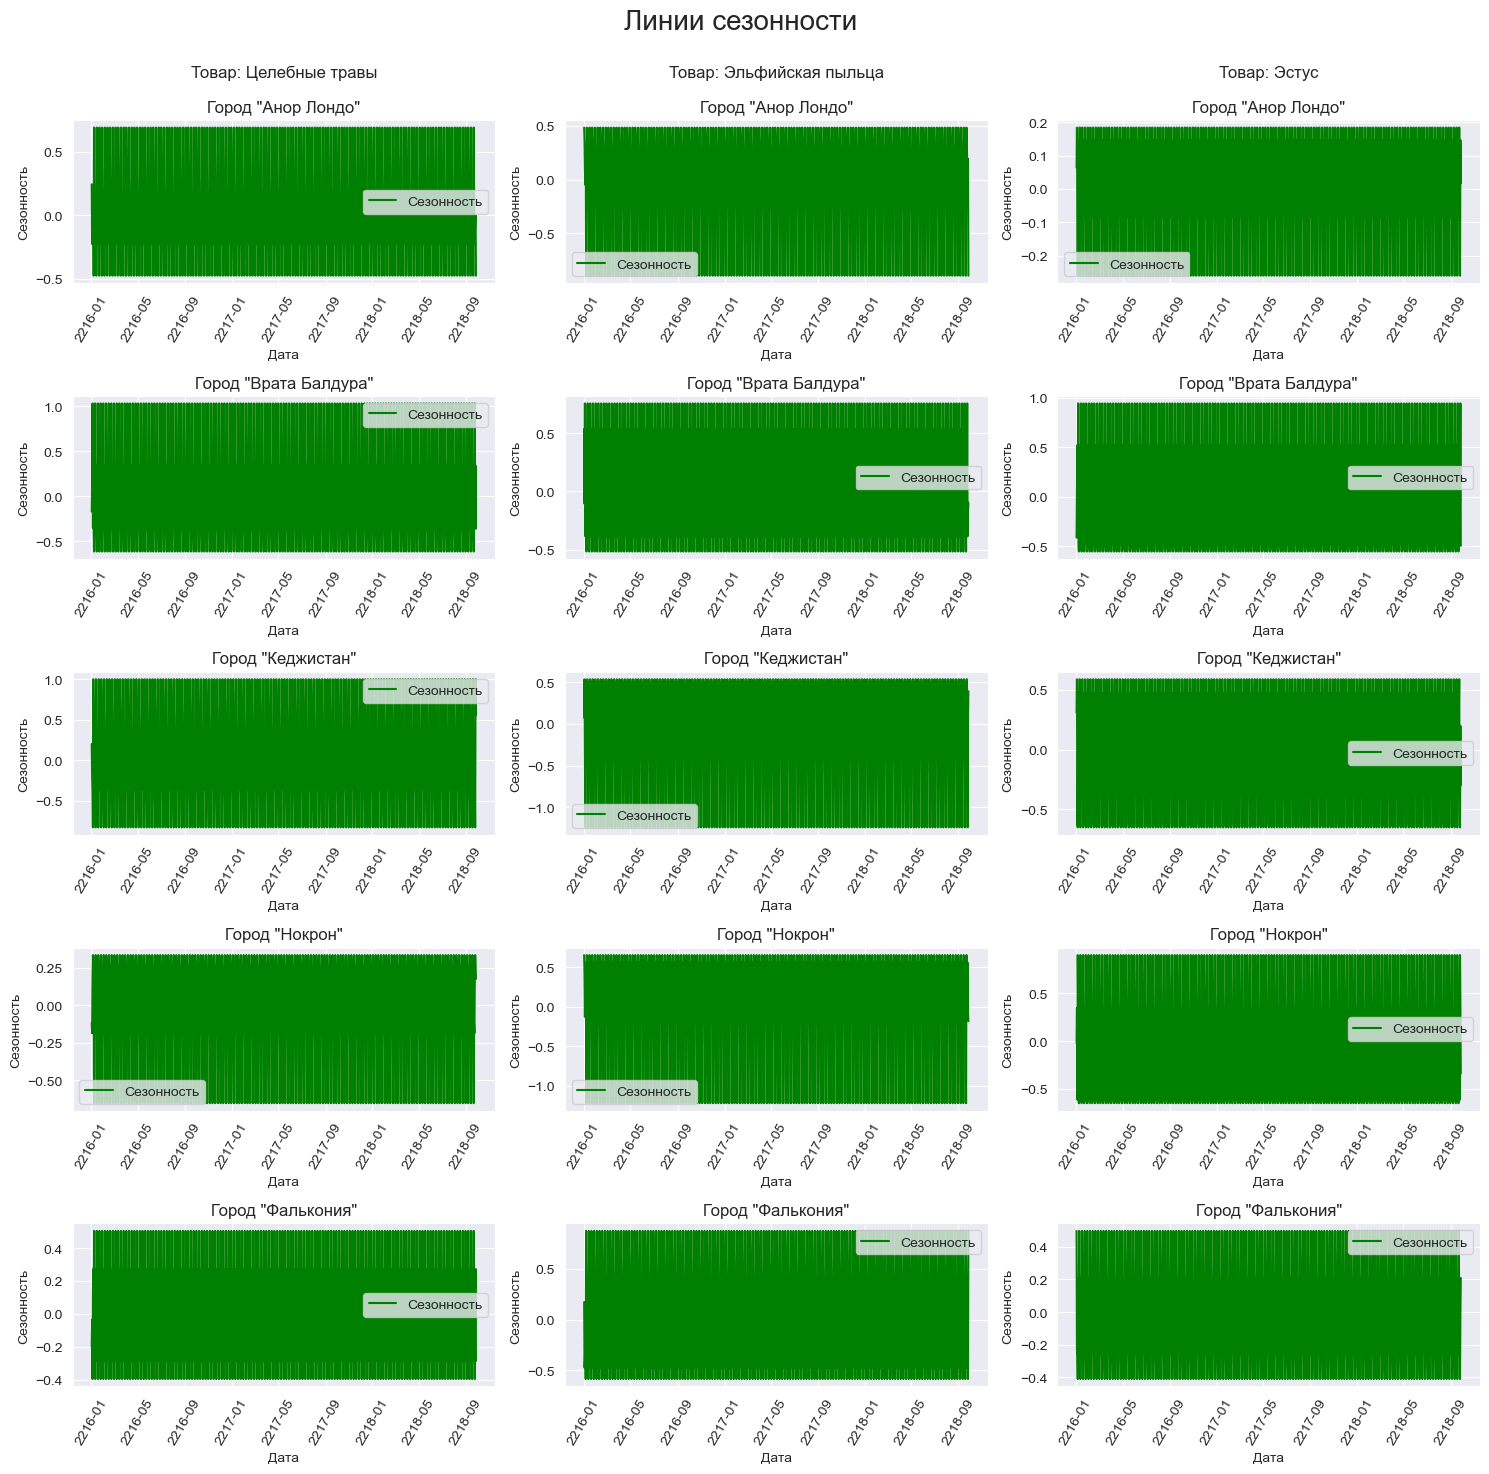

In [136]:
num_cols, num_rows = len(product_data_dict), len(list(product_data_dict.values())[0])
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# идем по словарю и индексам сетки для каждого товара и города
for col, (product, city_data) in enumerate(product_data_dict.items()):
    # сортируем по названию города для вывода по горизонтали одинаковых городов
    city_data_sorted = sorted(city_data.items(), key=lambda x: x[0])
    for row, (city, table) in enumerate(city_data_sorted):

        # применяем seasonal_decompose и получаем сезонность
        decomposition = seasonal_decompose(table['amount'], model='additive')
        seasonal = decomposition.seasonal

        # местоположение графика
        ax = axes[row, col]

        # строим график сезонности
        sns.lineplot(data=seasonal, ax=ax, color='green', label='Сезонность')
        ax.set_xlabel('Дата')
        ax.set_ylabel('Сезонность')
        ax.set_title(f'Город "{city}"', fontsize=12)

        # если это первый график в группе города, добавляем заголовок с названием товара
        if row == 0:
            ax.set_title(f'Товар: {product}\n \n{ax.get_title()}', fontsize=12)

fig.suptitle('Линии сезонности \n', fontsize=20)

for ax in axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(60)

# добавляем легенду
for ax in axes.flat:
    ax.legend()

plt.tight_layout()
plt.show()


Ничего не понятно, увеличим масштаб до месяца.

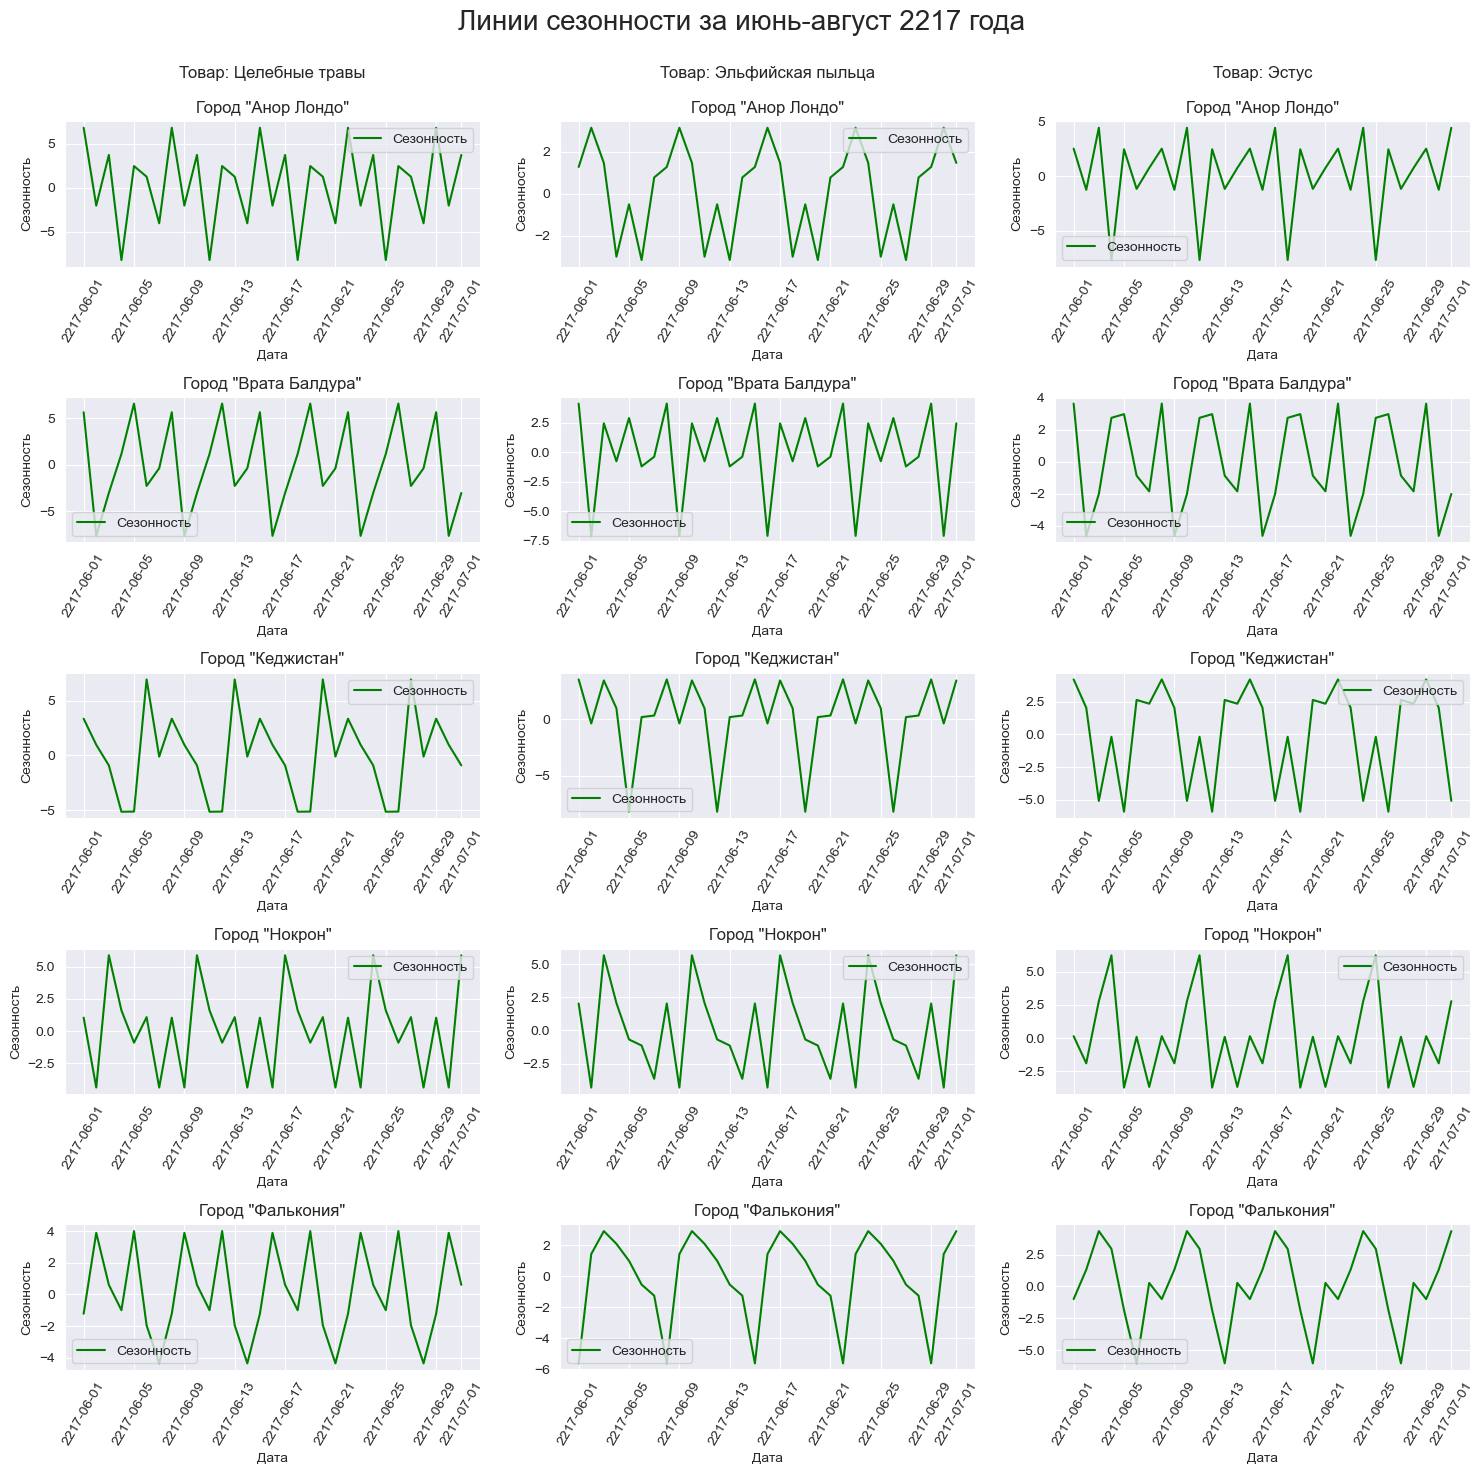

In [137]:
num_cols, num_rows = len(product_data_dict), len(list(product_data_dict.values())[0])
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# идем по словарю и индексам сетки для каждого товара и города
for col, (product, city_data) in enumerate(product_data_dict.items()):
    # сортируем по названию города для вывода по горизонтали одинаковых городов
    city_data_sorted = sorted(city_data.items(), key=lambda x: x[0])
    for row, (city, table) in enumerate(city_data_sorted):

        # выбираем данные за июнь июль и август 2217 года
        table = table.loc['2217-06-01':'2217-07-01']

        # применяем seasonal_decompose и получаем сезонность
        decomposition = seasonal_decompose(table['amount'], model='additive')
        seasonal = decomposition.seasonal

        # местоположение графика
        ax = axes[row, col]

        # строим график сезонности
        sns.lineplot(data=seasonal, ax=ax, color='green', label='Сезонность')
        ax.set_xlabel('Дата')
        ax.set_ylabel('Сезонность')
        ax.set_title(f'Город "{city}"', fontsize=12)

        # если это первый график в группе города, добавляем заголовок с названием товара
        if row == 0:
            ax.set_title(f'Товар: {product}\n \n{ax.get_title()}', fontsize=12)

fig.suptitle('Линии сезонности за июнь-август 2217 года \n', fontsize=20)

for ax in axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(60)

# добавляем легенду
for ax in axes.flat:
    ax.legend()

plt.tight_layout()
plt.show()


Видим чётко выраженную недельную сезонность.

Склеиваем ресемплированные данные обратно в датафрейм.

In [138]:
dataframes_list = [pd.DataFrame(product_data_dict[product_name][place_name]) \
                   for product_name in product_data_dict for place_name in product_data_dict[product_name]]

df_resampled = pd.concat(dataframes_list)
df_resampled = df_resampled.dropna()

In [139]:
df_resampled = df_resampled.reset_index()

### Данные о ценах конкурентов <a id="42"></a>

[К содержанию](#0)

Для адекватного прогноза и сравнения цен, нам нужно убедиться, что диапазон дат будет таким же, как и во всех остальных данных. Для этого мы так же выполним ресемплирование по одному дню, после чего объединим данные.

In [140]:
def resample_competitor_data(df_competitors, first_date_cc, last_date_cc):
    resampled_competitor_data = {}

    for (competitor, product, place), group_data in df_competitors.groupby(['competitor', 'product', 'place']):
        # ресемплирование данных
        resampled_data = group_data.resample('D').agg({
            'price': 'mean',
            'competitor': 'first',
            'place': 'first',
            'product': 'first'
        })

        # сохраняем диапазон дат
        resampled_data = resampled_data.reindex(index=pd.date_range(start=first_date_cc, end=last_date_cc, freq='D'))

        # заполняем пропуски
        resampled_data = resampled_data.bfill()
        resampled_data = resampled_data.ffill()
        
        resampled_data.index.name = 'date'

        # Добавление ресемплированных данных в словарь
        key = f"{competitor} {product} {place}"
        resampled_competitor_data[key] = resampled_data

    return resampled_competitor_data

resampled_competitor_data = resample_competitor_data(df_competitors, first_date_cc, last_date_cc)

In [141]:
all_tables = list(resampled_competitor_data.values())

df_comp_resampled = pd.concat(all_tables)
df_comp_resampled = df_comp_resampled.dropna()

Ресемплирование позволит нам восстановить примерную динамику цен и сопоставить их с нашими на таком же временном промежутке.

Построим графики для по ценам наших конкурентов.

In [142]:
df_comp_resampled = df_comp_resampled.reset_index()

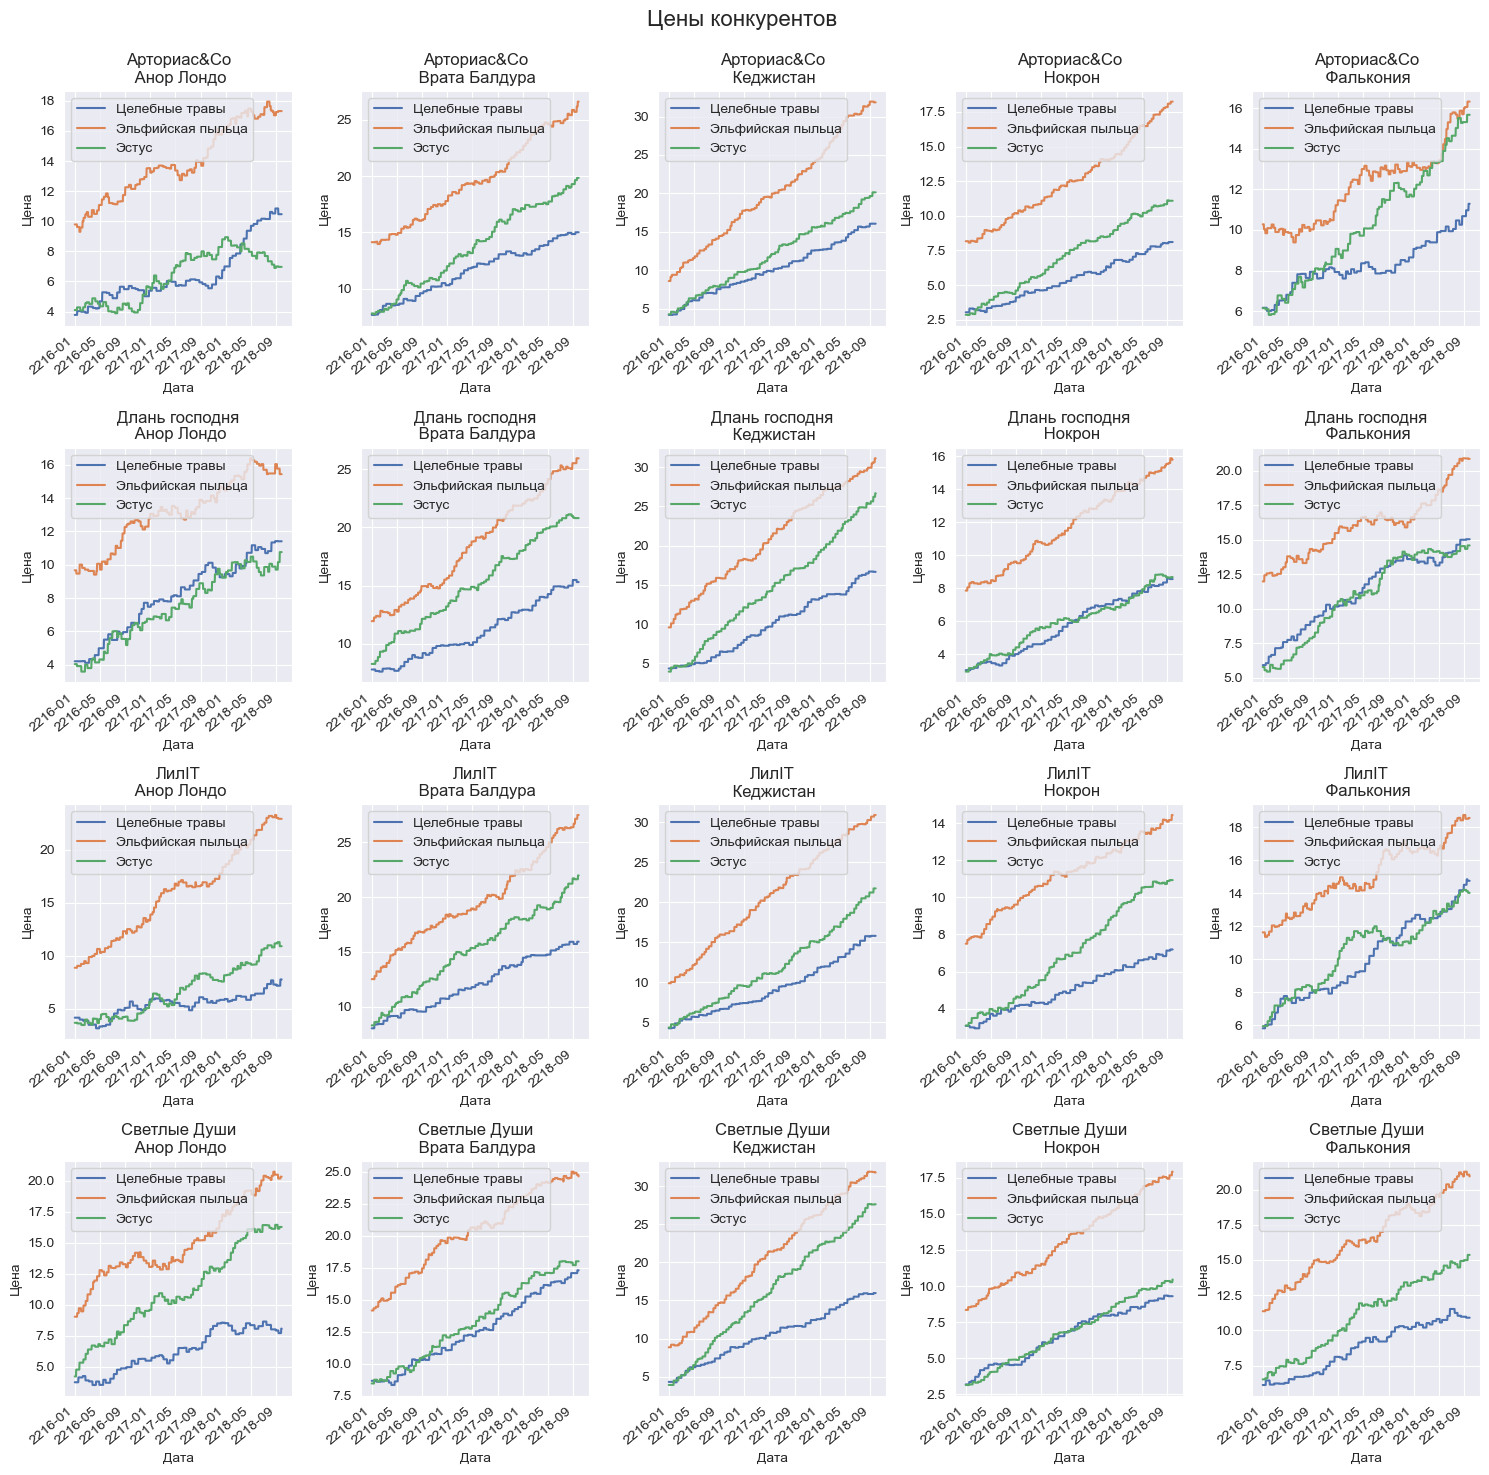

In [143]:
competitors = df_comp_resampled['competitor'].unique()
places = df_comp_resampled['place'].unique()

# создаем сетку графиков
fig, axes = plt.subplots(nrows=len(competitors), ncols=len(places), figsize=(15, 15))

for i, competitor in enumerate(competitors):
    for j, place in enumerate(places):
        ax = axes[i, j]
        subset = df_comp_resampled[(df_comp_resampled['competitor'] == competitor) & (df_comp_resampled['place'] == place)]
        
        # строим график для каждого товара
        for product, group in subset.groupby('product'):
            ax.plot(group['date'], group['price'], label=product)

        ax.set_title(place)
        ax.set_xlabel('Дата')
        ax.set_ylabel('Цена')
        ax.set_title(f'{competitor}\n {place}')
        ax.legend()
        
        # поворачиваем xticks
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=40, ha="right")

fig.suptitle('Цены конкурентов \n', fontsize=16)
plt.tight_layout()
plt.show()

Динамика цен на товары конкурентов совпадает с нашей, виден тренд на увеличение.

Объединим с нашими основными данными.

In [144]:
df_comp_pivot = df_comp_resampled.pivot_table(values = ['price'],
                             index =  ['date','place','product'],
                             columns = 'competitor',
                             aggfunc = {'price':'first'}).reset_index()
df_comp_pivot.columns = ['date','place','product','Арториас&Co_price',\
                         'Длань_господня_price','ЛилIT_price','Светлые_Души_price']
df_merged = pd.merge(df_resampled, df_comp_pivot, how = 'left', on = ['date', 'place', 'product'])

In [145]:
df_merged['price'] = df_merged['price'].round(2) # в паре строчек появились аномалии в долях после запятой
df_merged

date         product       place  price     amount  \
0     2216-01-02  Целебные травы  Анор Лондо   3.90  39.407787   
1     2216-01-03  Целебные травы  Анор Лондо   3.90  49.930460   
2     2216-01-04  Целебные травы  Анор Лондо   3.90  37.294680   
3     2216-01-05  Целебные травы  Анор Лондо   3.90  35.824029   
4     2216-01-06  Целебные травы  Анор Лондо   3.90  52.008217   
...          ...             ...         ...    ...        ...   
14995 2218-09-23           Эстус   Фалькония   9.28  63.375373   
14996 2218-09-24           Эстус   Фалькония   9.28  51.174297   
14997 2218-09-25           Эстус   Фалькония   9.28  62.867195   
14998 2218-09-26           Эстус   Фалькония   9.28  56.954178   
14999 2218-09-27           Эстус   Фалькония   9.28  48.223274   

       Арториас&Co_price  Длань_господня_price  ЛилIT_price  \
0                   3.78                  4.21         4.18   
1                   3.78                  4.21         4.18   
2                   3.78                  4.21         4.18   
3                   3.78                  4.21         4.18   
4                   3.78                  4.21         4.18   
...                  ...                   ...          ...   
14995              15.67                 14.58        14.02   
14996              15.67                 14.58        14.02   
14997              15.67                 14.58        14.02   
14998              15.67                 14.58        14.02   
14999              15.67                 14.58        14.02   

       Светлые_Души_price  
0                    3.75  
1                    3.75  
2                    3.75  
3                    3.75  
4                    3.75  
...                   ...  
14995               15.36  
14996               15.36  
14997               15.36  
14998               15.36  
14999               15.36  

[15000 rows x 9 columns]

Наш основной датасет содержит почти 15 тысяч записей о наших ценах и соответствующих ценах конкурентов. Посмотрим, можно ли его дополнить данными о себестоимости.

### Данные о себестоимости <a id="43"></a>

[К содержанию](#0)

In [146]:
df_cost

place         product  cost       date
0     Анор Лондо  Целебные травы  2.07 2216-01-02
1     Анор Лондо  Целебные травы  3.07 2216-01-26
2     Анор Лондо  Целебные травы  3.30 2216-02-12
3     Анор Лондо  Целебные травы  4.04 2216-03-06
4     Анор Лондо  Целебные травы  3.88 2216-03-27
...          ...             ...   ...        ...
1112   Фалькония           Эстус  3.10 2218-07-29
1113   Фалькония           Эстус  7.20 2218-08-10
1114   Фалькония           Эстус  3.31 2218-08-27
1115   Фалькония           Эстус  3.26 2218-09-16
1116   Фалькония           Эстус  7.29 2218-09-24

[1117 rows x 4 columns]

In [147]:
df_cost.set_index('date', inplace=True)
df_cost = df_cost.sort_index()

Мы знаем, что данных о себестоимости крайне мало. Построим графики для имеющихся наблюдений.

<Figure size 1500x1500 with 0 Axes>

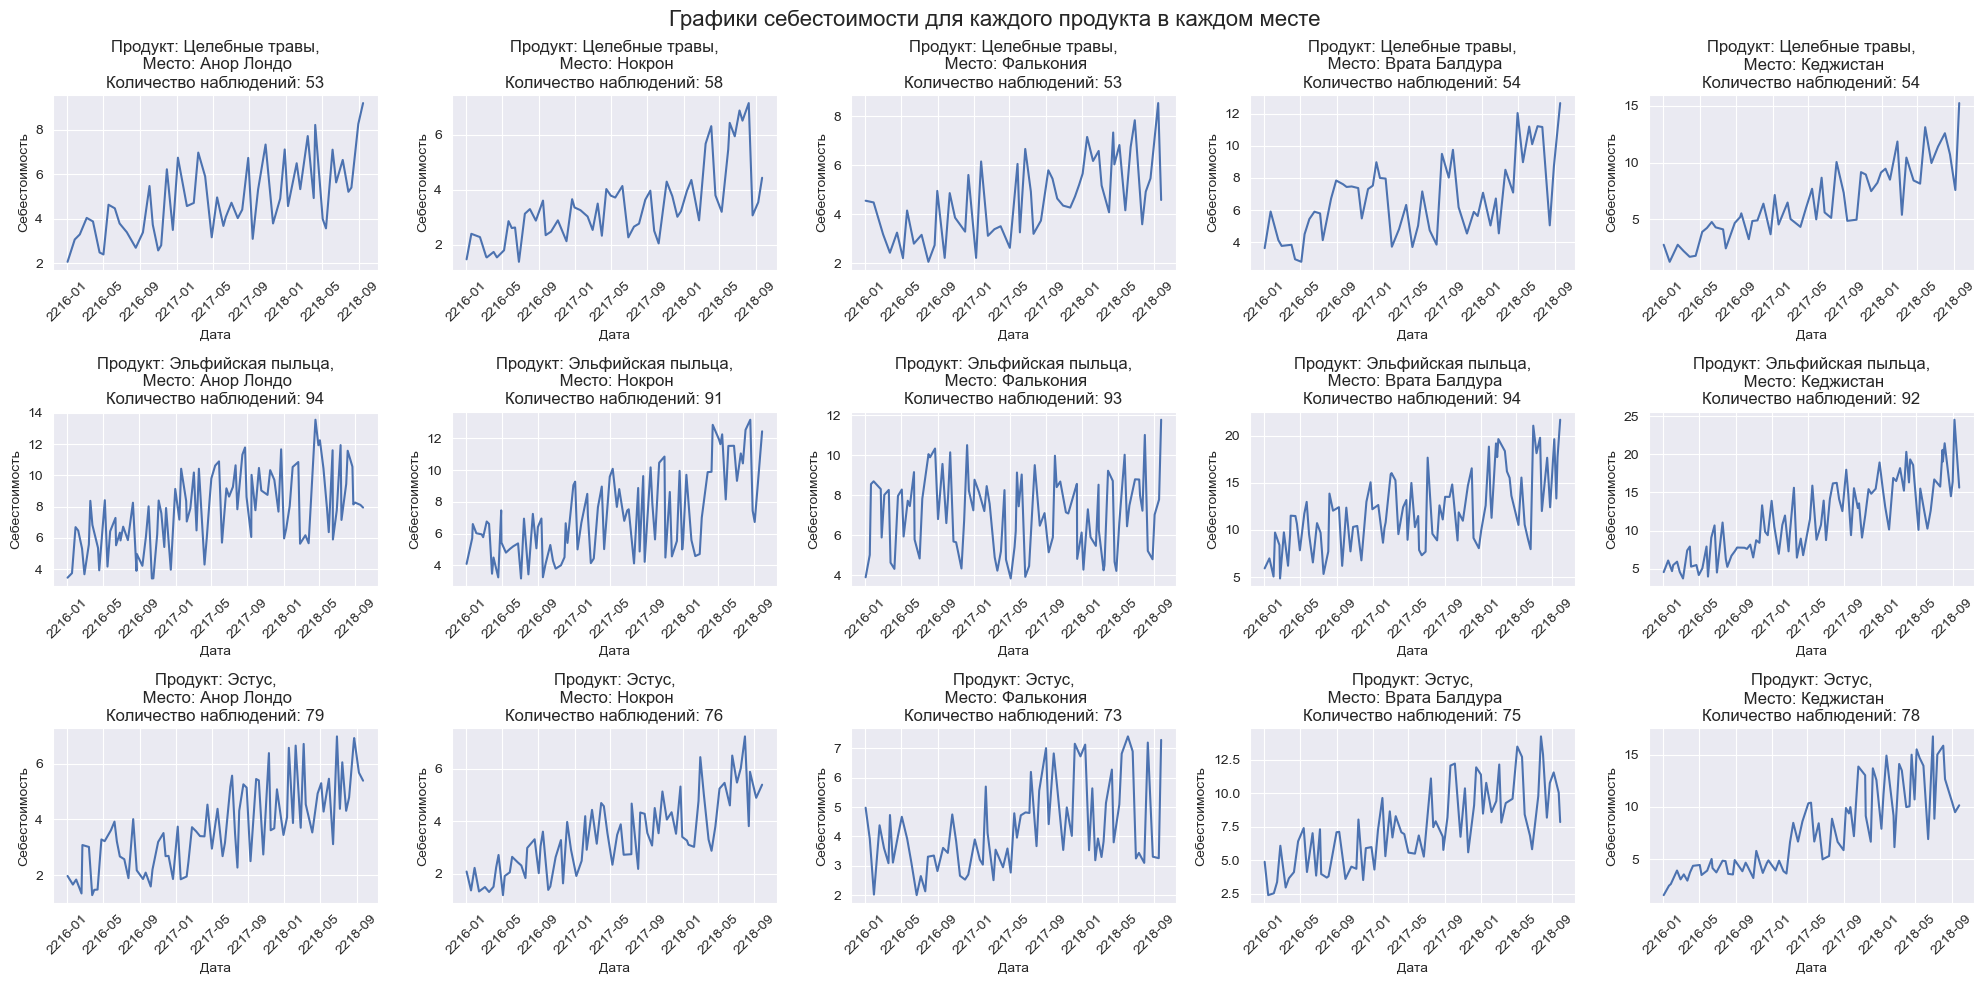

In [148]:
plt.figure(figsize=(15, 15))

products = df_cost['product'].unique()
places = df_cost['place'].unique()

rows = len(products)
cols = len(places)

fig, axes = plt.subplots(rows, cols, figsize=(20, 10))

fig.suptitle("Графики себестоимости для каждого продукта в каждом месте", size=16)

for i, product in enumerate(products):
    for j, place in enumerate(places):
        data = df_cost[(df_cost['product'] == product) & (df_cost['place'] == place)]
        ax = axes[i, j]
        sns.lineplot(data=data, x="date", y="cost", ax=ax)
        num_observations = len(data)  # количество наблюдений
        ax.set_title(f"Продукт: {product},\n Место: {place}\nКоличество наблюдений: {num_observations}")
        ax.set_xlabel("Дата")
        ax.set_ylabel('Себестоимость')
        for label in ax.get_xticklabels():
            label.set_rotation(45)

plt.tight_layout()
plt.show();

Можно видеть, что себестоимость имеет тенденцию к росту, но меняется слишком хаотично, а наблюдений по каждой отдельной позиции крайне мало.  Мы не сможем качественно спрогнозировать дальнейшие изменения себестоимости, чтобы использовать их. По каждой из позиций меньше 100 наблюдений. Увы, без дополнительной информации мы не сможем использовать эти данные.

Однако, мы можем предположить, что поставщик редко обновляет цену, и у нас есть данные только о её изменениях, а в остальное время она стабильна. Для этого, выполним ресемплирование данных и заполним промежутки предыдущими значениями.

In [149]:
# группируем по городу и товару
grouped = df_cost.groupby(['place', 'product'], group_keys=False)

tables_list = []

# идём по каждой группе
for name, group in grouped:
    # задаём диапазон
    full_date_range = pd.date_range(start='2216-01-02', end='2218-09-27', freq='D')
    full_df = pd.DataFrame(index=full_date_range)
    full_df.index.name = 'date'
    result_df = full_df.join(group, how='left').fillna(method='ffill')
    
    tables_list.append(result_df)

df_cost_resampled = pd.concat(tables_list)
df_cost_resampled = df_cost_resampled.reset_index()

Присоединим полученные данные к нашему датафрейму.

In [150]:
df_merged = pd.merge(df_merged, df_cost_resampled, how = 'left', on = ['date', 'place', 'product'])

### Данные о погоде <a id="44"></a>

[К содержанию](#0)

In [151]:
df_weather

date          place  hot  rain  snow  normal
0    2216-01-02      Фалькония    0     0     0       1
1    2216-01-02     Анор Лондо    1     0     0       0
2    2216-01-02  Врата Балдура    0     0     1       0
3    2216-01-02         Нокрон    0     0     0       1
4    2216-01-02      Кеджистан    0     0     1       0
...         ...            ...  ...   ...   ...     ...
4995 2218-09-27      Фалькония    0     0     0       1
4996 2218-09-27     Анор Лондо    0     0     1       0
4997 2218-09-27  Врата Балдура    1     0     0       0
4998 2218-09-27         Нокрон    0     0     0       1
4999 2218-09-27      Кеджистан    0     0     0       1

[5000 rows x 6 columns]

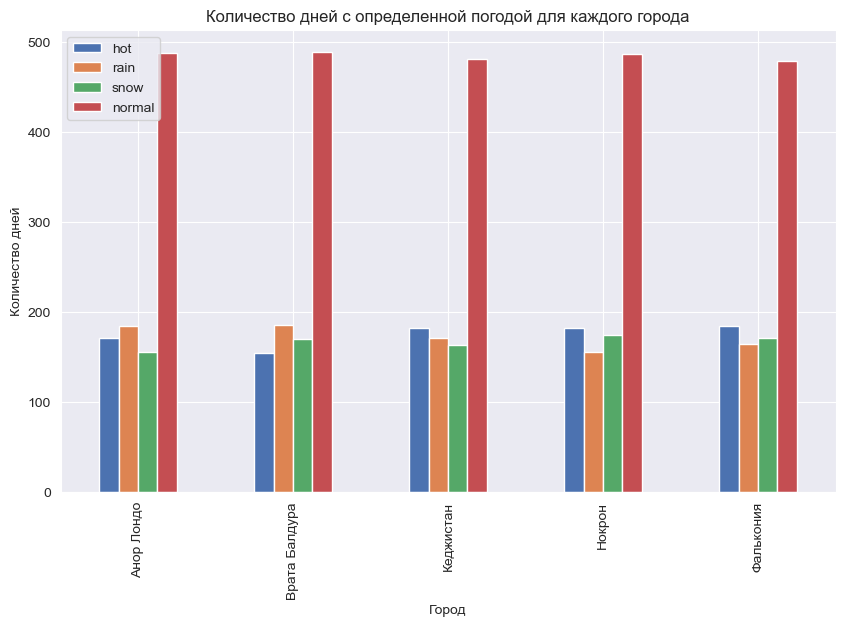

In [152]:
# общее количество дней с каждым типом погоды для каждого города
df_grouped = df_weather.groupby('place')[['hot', 'rain', 'snow', 'normal']].sum().reset_index()

# Визуализация
fig, ax = plt.subplots(figsize=(10, 6))

# Столбчатая диаграмма
df_grouped.plot(x='place', y=['hot', 'rain', 'snow', 'normal'], kind='bar', ax=ax)

ax.set_xlabel('Город')
ax.set_ylabel('Количество дней')
ax.set_title('Количество дней с определенной погодой для каждого города')
ax.legend(loc='upper left')
plt.show();

В целом, аномальные погодные явления более редкие, чем стабильная погода. Видно, что в Кеджистане, Нокроне и Фальконии чуть больше горячих дней, а в Анор Лондо и Вратах Балдура чаще идут дожди.

## Промежуточный вывод 2 <a id="5"></a>

[К содержанию](#0)

- т.к. нам нужно спрогнозировать цены на 90 дней вперёд, выполнено ресемплирование данных по 1 дню
- виден тренд на увеличение цены всех товаров во всех городах
- в Фальконии и Анор Лондо есть сильные колебания в ценах, прогноз в этих городах может быть нестабилен
- сезонность составляет 1 год, после этого цикл повторяется
- колебания и рост цен у конкурентов совпадают с нашими
- данных о себестоимости слишком мало, чтобы использовать их в качестве признаков мы так же выполнили ресемплирование и заполнили предыдущими значениями
- получен финальный датафрейм со всеми данными о наших ценах, ценах конкурентов и себестоимости

## Подготовка признаков и обучение моделей <a id="6"></a>

[К содержанию](#0)

Наша задача - определить, какую цену нужно выставить на товары на 90 дней вперёд. Итоговые значения будут зависеть от других неизвестных данных. Для решения задачи будем использовать следующий подход:
- спрогнозируем объём каждого товара
- спрогнозируем себестоимость каждого товара
- спрогнозируем цены каждого из конкурентов по каждому товару в каждом городе
- аналогично спрогнозируем нашу цену
- при каждом прогнозировании будем генерировать признаки из дня, недели, месяца и года, а так же лагов, для учёта предыдущих значений
- после получения прогнозов будем выполнять проверку на соответствие нашим правилам (цена меняется не чаще, чем раз в 3 дня и не больше, чем на 1 золотой за раз) и вносить правки
- после получения всех данных, сравним наши цены с ценами конкурентов (цена не должна быть дороже больше, чем на 20%) и внесем правки

Будем использовать линейную регрессию, т.к. простая модель позволит быстро посчитать большое количество прогнозов. Забегая вперёд, она в итоге показала себя лучше деревянных моделей и бустингов.

In [153]:
df_merged

date         product       place  price     amount  \
0     2216-01-02  Целебные травы  Анор Лондо   3.90  39.407787   
1     2216-01-03  Целебные травы  Анор Лондо   3.90  49.930460   
2     2216-01-04  Целебные травы  Анор Лондо   3.90  37.294680   
3     2216-01-05  Целебные травы  Анор Лондо   3.90  35.824029   
4     2216-01-06  Целебные травы  Анор Лондо   3.90  52.008217   
...          ...             ...         ...    ...        ...   
14995 2218-09-23           Эстус   Фалькония   9.28  63.375373   
14996 2218-09-24           Эстус   Фалькония   9.28  51.174297   
14997 2218-09-25           Эстус   Фалькония   9.28  62.867195   
14998 2218-09-26           Эстус   Фалькония   9.28  56.954178   
14999 2218-09-27           Эстус   Фалькония   9.28  48.223274   

       Арториас&Co_price  Длань_господня_price  ЛилIT_price  \
0                   3.78                  4.21         4.18   
1                   3.78                  4.21         4.18   
2                   3.78                  4.21         4.18   
3                   3.78                  4.21         4.18   
4                   3.78                  4.21         4.18   
...                  ...                   ...          ...   
14995              15.67                 14.58        14.02   
14996              15.67                 14.58        14.02   
14997              15.67                 14.58        14.02   
14998              15.67                 14.58        14.02   
14999              15.67                 14.58        14.02   

       Светлые_Души_price  cost  
0                    3.75  2.07  
1                    3.75  2.07  
2                    3.75  2.07  
3                    3.75  2.07  
4                    3.75  2.07  
...                   ...   ...  
14995               15.36  3.26  
14996               15.36  7.29  
14997               15.36  7.29  
14998               15.36  7.29  
14999               15.36  7.29  

[15000 rows x 10 columns]

In [154]:
df_merged = df_merged.set_index('date')

Зададим функцию для определения признаков - порядковый номер дня в неделе и месяце, год, и смещение ```lag``` для учёта предыдущих значений целевого признака.

In [155]:
def make_features(data, target):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['month'] = data.index.month
    data['year'] = data.index.year    
    for lag in range(1, 91):
        data['lag_{}'.format(lag)] = data[target].shift(lag)
    return data

Зададим функцию для формирования списка датасетов, в которых будем предсказывать целевой признак.

In [156]:
def get_df_list(target):
    grouped = df_merged.groupby(['product', 'place'])[[target]].apply(lambda x: x)
    df_list = [group.reset_index().set_index('date') for name, group in grouped.groupby(['product', 'place'])]
    return df_list

Зададим функцию ```fit```, которая будет принимать на вход датафрейм из нашего списка датафреймов, и тренировать модель для предсказания указанного признака. На выходе будем получать модель, обученную на кросс-валидации. Для учёта того, что наши данные упорядочены, при разбиении выборок используем ```TimeSeriesSplit```.

In [157]:
droplist = ['product', 'place']

def fit(df, target):
    # удаляем пропуски, определям обучающие и тестовые выборки
    df = df.dropna()
    train, test = train_test_split(df, shuffle=False, test_size=0.2)
    features_train = train.drop(droplist + [target], axis=1)
    features_test = test.drop(droplist + [target], axis=1)
    target_train = train[target]
    target_test = test[target]
    
    # Проверка показала, что масштабирование признаков не оказывает влияние на качество моделей
    # numeric = df.columns.drop(droplist + [target])
    # scaler = StandardScaler()
    # scaler.fit(features_train[numeric])
    # features_train[numeric] = scaler.transform(features_train[numeric])
    # features_test[numeric] = scaler.transform(features_test[numeric])
    
    # выберем MAE для удобной интерпретируемости ошибки
    score = make_scorer(mean_absolute_error, greater_is_better=False)
    tscv = TimeSeriesSplit(n_splits=5)
    
    # обучение модели
    model_lin_reg = LinearRegression()
    grid_lr = GridSearchCV(model_lin_reg, param_grid={}, scoring=score, cv=tscv, n_jobs=-1)
    grid_lr.fit(features_train, target_train)
    # print(f'{target} {product} в {place} Test MAE: ', -grid_lr.best_score_)
    model = grid_lr.best_estimator_
    
    # отрисовка и вывод результатов
    preds = pd.Series(model.predict(features_test))
    preds.index = target_test.index
    # target_train.plot()
    # target_test.plot()
    # preds.plot()
    # plt.show();
    product = df['product'].iloc[0]
    place = df['place'].iloc[0]
    print(f'{target} {product} в {place} Test MAE: ', mean_absolute_error(preds, target_test))
    
    # обучаем лучшую модель на полном наборе данных
    features_full = df.drop(droplist + [target], axis=1)
    target_full = df[target]
    model.fit(features_full, target_full)
    
    return model

Чтобы получить предсказания на 90 дней вперёд, мы будем идти по датафрейму, обновлять значения признаков для новых дней, и получать предсказания.

Зададим функции:
- ```add_horizon``` будет добавлять в наш текущий датафрейм пустые строки до даты, указанной в ```HORIZON``` и будет возвращать обновлённый датафрейм, и его последнюю дату
- ```predict``` будет получать предсказания на указанный день при помощи обученной модели
- ```clean``` будет убирать лишние столбцы и округлять наши предсказания (кроме ```amount```)

In [158]:
HORIZON = 90

def add_horizon(data, forecast_horizon):
    last_date = data.index.max()
    new_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), end=last_date + pd.DateOffset(days=forecast_horizon), freq='D')
    new_rows = pd.DataFrame(index=new_dates, columns=data.columns)
    data_new = pd.concat([data, new_rows], axis=0)
    data_new.index.name = 'date'
    return data_new, last_date

def predict(data, target, model):
    features = data.drop(target, axis = 1)
    pred = model.predict(features)
    return pred

droplist2 = ['day','dayofweek', 'month','year']
def clean(df, target):
    for lag in range(1, 91):
        df = df.drop(['lag_{}'.format(lag)], axis = 1)
    df = df.drop(droplist2, axis = 1)
    df['product'].fillna(method='ffill', inplace=True)
    df['place'].fillna(method='ffill', inplace=True)
    if target != 'amount':
        df[target] = df[target].round(2)
    return df

Зададим основную функцию ```get_predicts```, которая будет проходиться по датафрейму, добавлять в него горизонт прогнозирования, получать предсказания и добавлять их в датафрейм.

In [159]:
def get_predicts(df_list, target):
    
    # идём по каждому датафрейму в списке
    for i in range(0, len(df_list)): 
        
        # # костыль, т.к. в двух таблицах на каком-то из этапов отвалились 3 последних дня
        # # в целом не критично, но если останется время, надо будет поправить
        # if i in (6, 14):
        #     current_horizon = HORIZON + 3
        # else:
        #     current_horizon = HORIZON
        
        # подгоняем модель на текущем датасете
        model = fit(make_features(df_list[i], target), target)
        
        # добавляем горизонт прогнозирования и генерируем признаки
        df_list[i], last_date = add_horizon(df_list[i], HORIZON)
        df_list[i] = make_features(df_list[i], target)
        
        # здесь идём по прогнозируемым дням построчно, обновляем признаки
        # получем срез в виде фичей на следующий день,
        # затем получаем предсказание, и добавляем его в датафрейм
        # после получения всех предсказаний, чистим датафрейм от сгенерированных фичей
        for j in range(0, HORIZON + 1):
            df_list[i] = make_features(df_list[i], target)
            t = pd.DataFrame(df_list[i].loc[last_date + pd.Timedelta(days=j)]).transpose().drop(droplist, axis=1)
            p = predict(t, target, model)
            df_list[i].loc[last_date + pd.Timedelta(days=j), target] = p
        df_list[i] = clean(df_list[i], target)
    
    return df_list

После получения всех предсказаний, мы сразу же будем проверять их на соответствие нашим условиям:
- цена изменяется не чаще, чем раз в 3 дня
- цена изменяется не больше, чем на 1 за раз

Для этого зададим функцию ```fixprice```, которая будет выполнять проверку.

In [160]:
def fixprice(df, target):
    if target in ['amount', 'cost']: # для количества товара и себестоимости правила не действуют
        pass
    else:
        for i in range(0, len(df), 3):
            current_value = df.loc[df.index[i], target]
            df.loc[df.index[i:i+3], target] = current_value
            if i > 0 and abs(current_value - df.loc[df.index[i-3], target]) > 1:
                df.loc[df.index[i:i+3], target] = df.loc[df.index[i-3], target] + 0.99
    return df

Зададим список целевых переменных. Для каждой из них будем получать список датафреймов с данными по каждому товару в каждом городе, тренировать модель, и получать предсказания на 90 дней вперёд. Затем объединяем результаты и финальный датафрейм.

In [161]:
TARGETS = ['price', 'amount','Арториас&Co_price','Длань_господня_price','ЛилIT_price','Светлые_Души_price', 'cost']
final_df = pd.DataFrame()
for t in TARGETS:
    df_list = get_df_list(t)
    df_list = get_predicts(df_list, t)
    for i in range(0, len(df_list)):
        df_list[i] = fixprice(df_list[i], t)
        df_list[i]['day_num'] = range(HORIZON, HORIZON - len(df_list[i]), -1) #костыль для правильной нумерации дней
        df_list[i]['day_num'] = df_list[i]['day_num'].values[::-1]
    merged_df = pd.concat(df_list)
    final_df['product'] = merged_df['product']
    final_df['place'] = merged_df['place']
    final_df['day_num'] = merged_df['day_num']
    final_df[t] = merged_df[t]

price Целебные травы в Анор Лондо Test MAE:  0.062450964075302345
price Целебные травы в Врата Балдура Test MAE:  0.02500231358448662
price Целебные травы в Кеджистан Test MAE:  0.0432242058498848
price Целебные травы в Нокрон Test MAE:  0.02276899610446821
price Целебные травы в Фалькония Test MAE:  0.025693412213452733
price Эльфийская пыльца в Анор Лондо Test MAE:  0.06035781218635828
price Эльфийская пыльца в Врата Балдура Test MAE:  0.04322227293698979
price Эльфийская пыльца в Кеджистан Test MAE:  0.056578392428109754
price Эльфийская пыльца в Нокрон Test MAE:  0.038199145257559644
price Эльфийская пыльца в Фалькония Test MAE:  0.05359112281909741
price Эстус в Анор Лондо Test MAE:  0.04433699348791938
price Эстус в Врата Балдура Test MAE:  0.042272177939149835
price Эстус в Кеджистан Test MAE:  0.06221724360129234
price Эстус в Нокрон Test MAE:  0.029713008012762294
price Эстус в Фалькония Test MAE:  0.04126956600057819
amount Целебные травы в Анор Лондо Test MAE:  7.28609407963

Как можно видеть, модели хорошо обучаются:

- предсказания цен точны вплоть до нескольких серебрянных монет (в худшем случае, 0.2 - 20 серебрянных)
- предсказания себестоимости немного хуже - ошибка может составлять 30-40 серебрянных монет, но в целом, результат всё ещё приемлемый
- с предсказаниями количества товара модели справляются хуже, может потребоваться дополнительный анализ и другой подход к генерации признаков

После получения финального датасета нам нужно сравнить наши цены с ценами конкурентов. Наша цена не должно отличаться от цен конкурентов больше, чем на 20%.

Мы уверены в качестве нашего товара, но жадность может погубить бизнес, поэтому будем ориентироваться на минимальную цену конкурентов:
- если спрогнозированная цена оказалась меньше минимальной, ставим + 10% от минимальной
- если спрогнозированная цена больше минимальной на 20%, ставим + 15%

Такая схема ценообразования позволит нам держаться в середине, а значит, покупатели всегда будут довольны адекватной ценой наших товаров. В случае смены стратегии, можно легко поменять схему, к примеру, ориентироваться на среднюю, или максимальную цену конкурентов.

In [162]:
competitors = ['Арториас&Co_price','Длань_господня_price','ЛилIT_price','Светлые_Души_price']

def fixprice2(df, competitors):
    for i in range(0, len(df)):
        min_price = df.iloc[i][competitors].min()
        threshold = 1.2  # пороговое значение 20%
        
        if df.iloc[i]['price'] < min_price:
            df.loc[df.index[i], 'price'] = round(min_price * 1.1, 2)
        if df.iloc[i]['price'] > min_price * threshold:
            df.loc[df.index[i], 'price'] = round(min_price * 1.15, 2)

    return df

In [163]:
final_df = final_df.reset_index()
final_df = fixprice2(final_df, competitors)

In [164]:
final_df

date         product       place  day_num  price     amount  \
0     2216-01-02  Целебные травы  Анор Лондо     -999   3.90  39.407787   
1     2216-01-03  Целебные травы  Анор Лондо     -998   3.90  49.930460   
2     2216-01-04  Целебные травы  Анор Лондо     -997   3.90  37.294680   
3     2216-01-05  Целебные травы  Анор Лондо     -996   3.90  35.824029   
4     2216-01-06  Целебные травы  Анор Лондо     -995   3.90  52.008217   
...          ...             ...         ...      ...    ...        ...   
16345 2218-12-22           Эстус   Фалькония       86  15.54  53.259855   
16346 2218-12-23           Эстус   Фалькония       87  15.57  50.899687   
16347 2218-12-24           Эстус   Фалькония       88  15.57  52.057377   
16348 2218-12-25           Эстус   Фалькония       89  15.57  52.743136   
16349 2218-12-26           Эстус   Фалькония       90  15.55  53.778963   

       Арториас&Co_price  Длань_господня_price  ЛилIT_price  \
0                   3.78                  4.21         4.18   
1                   3.78                  4.21         4.18   
2                   3.78                  4.21         4.18   
3                   3.78                  4.21         4.18   
4                   3.78                  4.21         4.18   
...                  ...                   ...          ...   
16345              15.99                 15.62        14.13   
16346              16.02                 15.66        14.15   
16347              16.02                 15.66        14.15   
16348              16.02                 15.66        14.15   
16349              16.03                 15.72        14.14   

       Светлые_Души_price  cost  
0                    3.75  2.07  
1                    3.75  2.07  
2                    3.75  2.07  
3                    3.75  2.07  
4                    3.75  2.07  
...                   ...   ...  
16345               16.22  6.42  
16346               16.25  6.44  
16347               16.25  6.47  
16348               16.25  6.44  
16349               16.27  6.14  

[16350 rows x 11 columns]

In [165]:
first_date = df_merged.index.max() # от последней даты объединённого датафрейма
last_date = first_date + pd.DateOffset(days = HORIZON) # на период, заданный горизонтом прогнозирования
recent_data = final_df[(final_df['date'] > first_date) & (final_df['date'] <= last_date)] # получаем срез
result = recent_data[['day_num', 'place', 'product', 'price']].reset_index(drop = True)
result

day_num       place         product  price
0           1  Анор Лондо  Целебные травы   8.96
1           2  Анор Лондо  Целебные травы   8.96
2           3  Анор Лондо  Целебные травы   8.88
3           4  Анор Лондо  Целебные травы   8.88
4           5  Анор Лондо  Целебные травы   8.88
...       ...         ...             ...    ...
1345       86   Фалькония           Эстус  15.54
1346       87   Фалькония           Эстус  15.57
1347       88   Фалькония           Эстус  15.57
1348       89   Фалькония           Эстус  15.57
1349       90   Фалькония           Эстус  15.55

[1350 rows x 4 columns]

Результат корректный, сохраняем данные.

In [166]:
result.to_parquet('result')

## Вывод <a id="7"></a>

[К содержанию](#0)

Нами были проанализированы и изучены исторические данные о ценах на товары в различных города.

**После этапа загрузки и предобработки:**

- в данных о транзакциях:
    - основывась на имеющихся данных об аномалиях, пропуски в городах и отрицательные значения в цене заполнены соседними значениями
    - удалены изменения цены, не соответствующие правилам (если новая цена держалась меньше 3 дней или изменилась больше чем на 1)
    - основываясь на значениях аномалий, отрицательные значения в количестве товара были заменены на такие же положительные
- в данных о погоде обработаны строки с нулями во всех категориях — добавлен столбец ```normal```, означающий нормальную погоду, без жары, дождя или снега

**После исследования и анализа данных:**

- выполнено ресемплирование данных по 1 дню, заполнены некоторые недостающие дни в ценах конкурентов, все данные приведены к одному диапазону дат
- виден тренд на увеличение цены всех товаров во всех городах
- в Фальконии и Анор Лондо есть сильные колебания в ценах, прогноз в этих городах может быть нестабилен
- сезонность составляет 1 год, после этого цикл повторяется
- в данных об объеме товара есть недельная сезонность
- рост и колебания цен у конкурентов совпадают с нашими
- получен финальный датафрейм со всеми данными о наших ценах, ценах конкурентов и себестоимости
- определена стратегия для получения решения

**На этапе обучения моделей:**

- для получения предсказаний выбрана модель линейной регрессии
- в качестве метрики выбрана средняя абсолютная ошибка, т.к. её значения удобно интерпретировать
- наш объединенный датафрейм разбивается на списки отдельных таблиц, с соответвтвующим целевым признаком
- в каждой таблице формируются признаки, такие как номер дня в месяце, номер недели, год, и лаги для учёта предыдущих значений
- происходит обучение моделей на кросс-валидации, лучшая модель прогоняется на полном наборе данных
- модели хорошо обучаются и при прогнозах цен в среднем ошибаются на 2-8 серебрянных монет
- в каждую таблицу добавляются пустые строки для горизонта прогнозирования и обновляются признаки (мы можем получить значения лагов на 1 день вперёд)
- модель делает предсказание, и оно заносится в соответствующую таблицу
- после получения всех предсказаний, данные проверяются на соответствие нашим правилам ценообразования, а так же, сравниваются с ценами конкурентов
- чтобы не завышать цены, выбрана стратегия сравнения с минимальной ценой (не больше 20% от минимальной среди всех конкурентов) — если наша цена более чем на 20% больше минимальной цены конкурента, уменьшаем разницу до 15%, если меньше минимальной - ставим +10%
- скорректированные данные объединяются в финальный датафрейм
- из финального датафрейма мы получаем интересующий наз срез с нашими предсказаниями, и сохраняем в паркет
- написаны функции для всех основных действий для удобства и дальнейшей модификации

**Варианты дальнейшей доработки:**

- дооформить код из этапа анализа, обернуть в функции ресемплирование и визуализацию
- более детально проанализировать объём товара и построить для его прогнозирования отдельную модель (с учётом скользящего среднего и отдельных месяцев)
- построить модель для прогнозирования данных о погоде, чтобы использовать их в качестве признаков
- пересмотреть ценообразование с учётом себестоимости и формулы прибыли
    - сейчас цена основывается только на наших прогнозах после анализа исторических данных, и на ценах конкурентов
    - даже если учесть формулу и максимизировать прибыль, задача всё равно будет решаться выставлением цены  относительно цен конкурентов, можно придумать другой способ, если получится собрать больше данных
- обернуть в функции этап предобработки данных
- написать скрипт, который будет выполнять предобработку и получать предсказания из такого же набора данных за другой период
